# Classification Tutorial

This notebook goes a bit beyond the video lecture version, especially in the discussions of how to evaluate a classifier (Section 6,and Appendix B) and in the discussion of dimensionality reduction (Section 7).  The quiz and discussion questions do include material from those sections, so be sure to read through them.

Note for followers of the original notebook set:  This notebook incorporates the material of the plot_iris_svc.ipynb notebook and therefore supercedes it.

## Performance and Explainability


The picture below is taken from the following  Amazon AWS article, which is highly recommended.

https://docs.aws.amazon.com/whitepapers/latest/model-explainability-aws-ai-ml/interpretability-versus-explainability.html

It is a somewhat fanciful visualization of a very real and much-discussed challenge in Machine
Learning ---  the negative correlation between iterpretability and performance.  The best-performing
systems are often extremely hard to interpret,  

What is interpretability?  According to the Amazon AWS article:

>[If developers] want to understand exactly why and how the model is generating predictions, they need to observe the inner mechanics of the AI/ML method. This leads to **interpreting** the model’s weights and features to determine the given output. This is interpretability.

That is, it is hard to decompose the system into
meaningful factors or components, and therefore to understand what aspects of the data it is using
to achieve success in it predictions.  The "features" being used by the system to represent
data (typically long vectors of real numbers) have no natural interpretations, and therefore, neither
do their weights.  One consequence of this is that, when there is a problem, the system is impossible to tweak.  Both the system parameters and hyperparameters are hard to modify in a way that successfully addresses a particular shortcoming.  Instead, improvements are achieved by getting more training data or rebalancing the data or architectural changes.


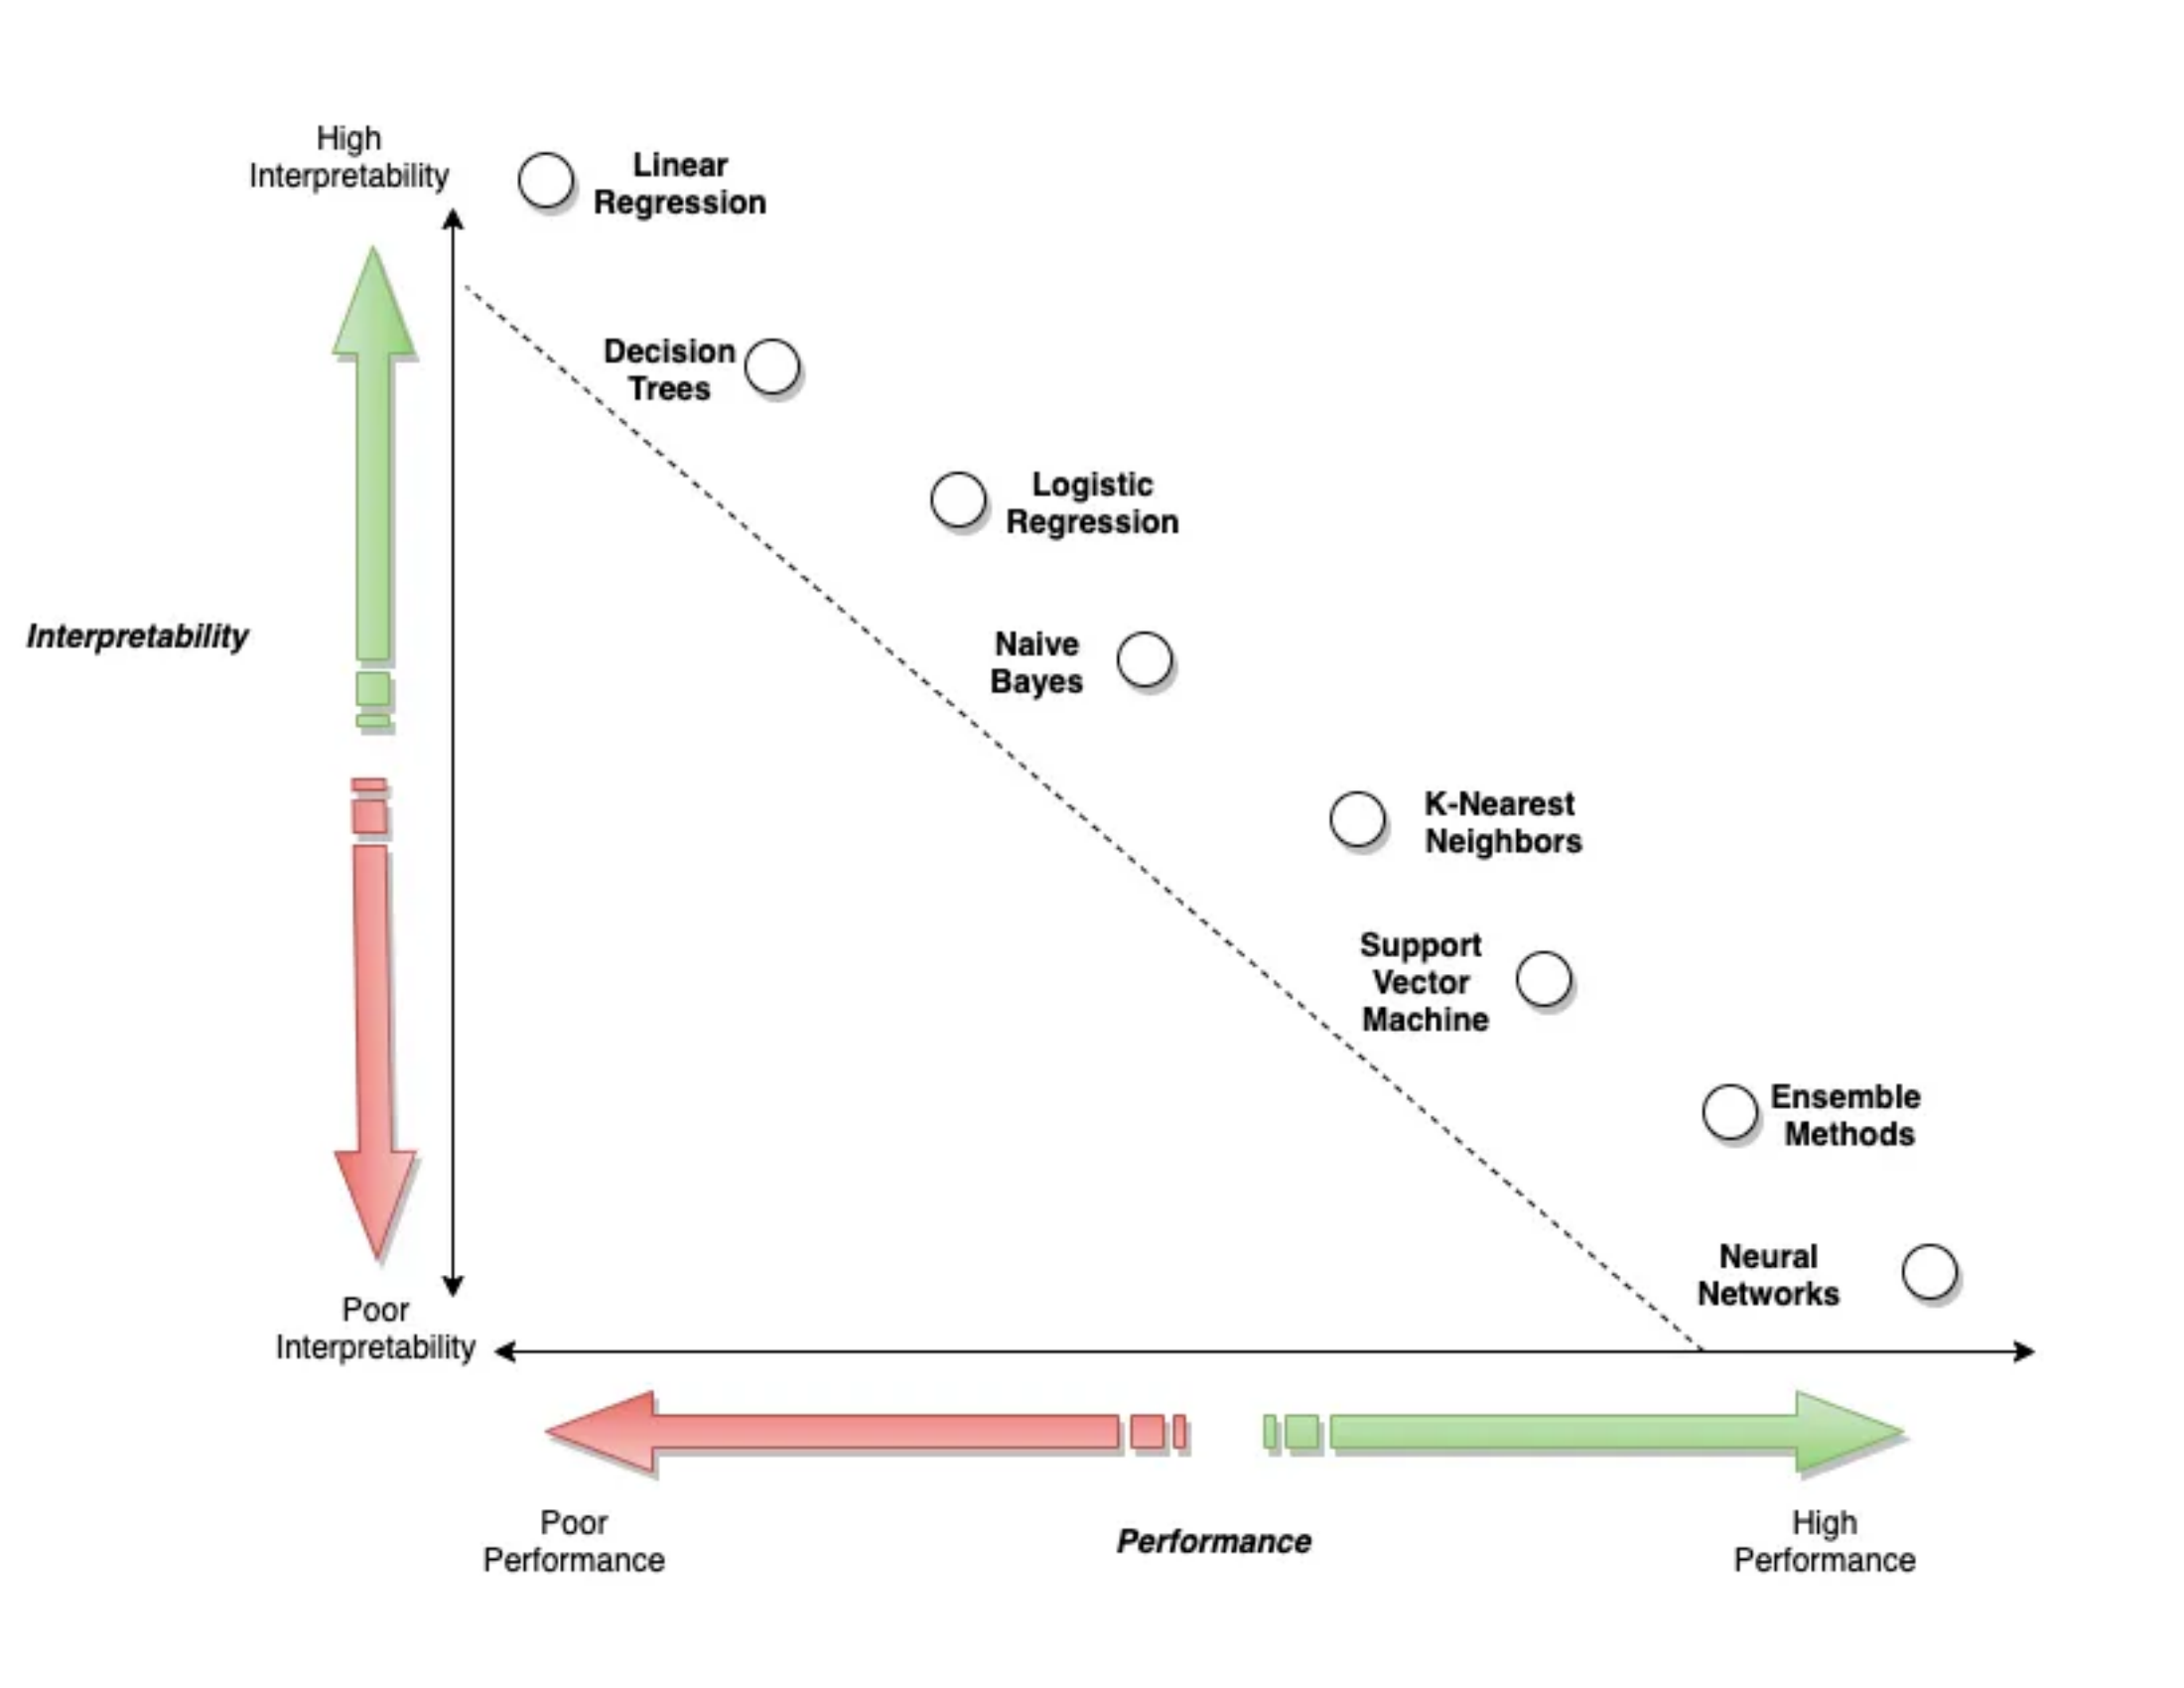

In [4]:
import IPython
#img_url ="https://github.com/gawron/python-for-social-science/blob/master/text_classification/"\
#          "performance_explainability_tradeoff_AWS.png"
#img_url ="https://github.com/gawron/python-for-social-science/text_classification/"\
#          "performance_explainability_tradeoff_AWS.png"
img_url = "https://raw.githubusercontent.com/gawron/python-for-social-science/master/text_classification/"\
         "performance_explainability_tradeoff_AWS.png"
#img_url = 'https://gawron.sdsu.edu/performance_explainability_tradeoff_AWS.png'
IPython.display.Image(url=img_url,width=700,embed=True)

Some of the details of the above picture are questionable.  In a very concrete mathematical, sense Linear Regression, Logistic Regression, Naive Bayes, and Support Vector Machines are all equally interpretable, because they belong to a class of linear classifiers which predict using a linear comobination of the feature values, so to the extent the features are interpretable, the models are.  We'll demonstrate this in the text classification  assignment, where the features are the words that occur in a document.  Whether the interpretations we get from that mathematical picture make sense of our predictions is another question.  That question is **explainability**.  Can we relate our learner's prdedictions to known facts about its learning input?  We'll see that interpretability and explaibility are independent: You can have either one without the other.

Despite issues of detail in the picture it captures some intuitive facts and a general trend.  The most powerful learning methods, the neural networks, are the least interpretable.  Good old linear regression is the easiest to understand.

Let's look at some examples.

## 1. The data

Let's look at a dataset used in [one of the foundational papers in **linear discriminant analysis** (LDA) by Ronald Fisher](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwiez6rWgNbOAhVBVWMKHf6WCTAQFgghMAA&url=http%3A%2F%2Frcs.chemometrics.ru%2FTutorials%2Fclassification%2FFisher.pdf&usg=AFQjCNHHtp94F4ypoDjy-708tnsnREUZBw). The data was actually collected by Edgar Anderson in
a study of the morphological variation of iris species (variation due to **shape**).

First we load the data from the `sklearn` module, which contains many tools and datasets
used in machine learning research.

In [7]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn.svm import LinearSVC

data = load_iris()
features = data['data']
feature_names = data['feature_names']
target = data['target']

Two large arrays are defined, `features` and `target`.

The raw data about the irises is in `features`; `features` is a 2D array.

In [2]:
features.shape

(150, 4)

That means we have 150 data exemplars (individual irises), and we have 4 measured attributes for each.  

Here's the first 10 rows

In [3]:
features[:10]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

To understand what the data means,  consider an example iris. Let's take the row
90 rows up from the end of the array.

In [4]:
P = features[-90]
P

array([5. , 2. , 3.5, 1. ])

Looking at feature names, we can decode this:

In [5]:
#Defined above as feature_names = data['feature_names']
feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

P is an iris with sepal length 5 cm, sepal width 2 cm, petal length 3.5 cm,
and petal width 1 cm.  All of these are shape attributes.

P also has a class, stored in the `target` array, whose first ten members are:

In [7]:
#Defined above as target = data['']
target[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

To find  the class of our example iris, we look at the class of the iris 90 irises up from the last iris:

In [8]:
target[-90]

1

So P belongs to class 1.  It turns out there are three classes, all numerical.  We can see there are 3 classes and what they are by doing the following:

In [9]:
set(target)

{0, 1, 2}

In [10]:
target_names = data['target_names']
target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [11]:
# equivalent to target_names[1]
target_names[target[-90]]

'versicolor'

Each number in `target` represents a different species of iris, 0 = *I. setosa, 1 = I. versicolor,* and
2 = *I. virginica*. In fact our data has 50 exemplars of each of these 3 species.  So what this data helps us study is variation in the shape attributes in `feature_names`  among iris species.

The `target` array lets us select rows by species number.

If we want to select rows by species name instead of species number,
we do fancy indexing of the array `target_names` --- using `target` as our sequence
of indices--- to induce a sequence of species names:

In [12]:
print(target_names)
target_names[target]

['setosa' 'versicolor' 'virginica']


array(['setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'setosa', 'setosa', 'setosa', 'setosa',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'versicolor', 'versicolor', 'versicolor',
       'versicolo

And that sequence can be used for row selection.  Here are the first 5 rows of
species "Versicolor".

In [13]:
features[target_names[target]=="versicolor"][:5]

array([[7. , 3.2, 4.7, 1.4],
       [6.4, 3.2, 4.5, 1.5],
       [6.9, 3.1, 4.9, 1.5],
       [5.5, 2.3, 4. , 1.3],
       [6.5, 2.8, 4.6, 1.5]])

Life can sometines be a little easier if we load the data as a DataFrame.

In [14]:
#print(load_iris.__doc__)
data2 = load_iris(as_frame=True)
features_df = data2.data
target2 = data2.target#['target']
features_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


In [15]:
data2.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

The class information is in a Series with same index as `features_df`:

In [17]:
target2

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: target, Length: 150, dtype: int64

And here is what we did above --- selecting rows by species names ---  adapted
to the data in DataFrame form.

In [18]:
features_df[data2.target_names[target2]=="versicolor"][:5]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
50,7.0,3.2,4.7,1.4
51,6.4,3.2,4.5,1.5
52,6.9,3.1,4.9,1.5
53,5.5,2.3,4.0,1.3
54,6.5,2.8,4.6,1.5


Having given this one example of how to do things with data represented in two different
ways, for the rest of the notebook we'll work with the data in numpy array form.

It's a useful exercise to convert the code we've provided here for working with numpy arrays
into code that works with pandas DataFrames.  If you can do that in most
cases with little change to the structure of the code, you've demonstrated
significant fluency with pandas.

When we plot individual points below, we'll use the plotting function `scatter` and we'll distinguish species and by color and marker shape.  Here's how that works.

In the plot below: the the red point uses  marker shape ">",
the green point uses marker shape "o" and the blue point uses "x".

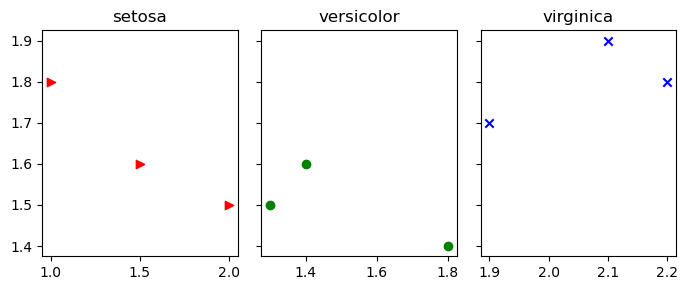

In [7]:
from matplotlib import pyplot as plt
import numpy as np

fig,axes = plt.subplots(1,3,figsize=(7,3),sharey=True)
markers, colors  = ">ox", "rgb"
X = np.array([[1,1.5,2],[1.3,1.4,1.8], [2.1,1.9,2.2]])
Y = np.array([[1.8,1.6,1.5], [1.5,1.6,1.4], [1.9,1.7,1.8]])
# Scattering  points different marker, different colors
for i in range(3):
    axes[i].scatter(X[i,:],Y[i,:],marker=markers[i],c=colors[i])
    axes[i].set_title(f"{data.target_names[i]}")
fig.tight_layout()

## 2. Plotting attributes

One way to get a feel of the how the attributes vary among the 3 species is to do histograms for each of the 4 attributes and each of the 3 species.

Text(0.5, 0.98, 'Attribute distributions for the three species')

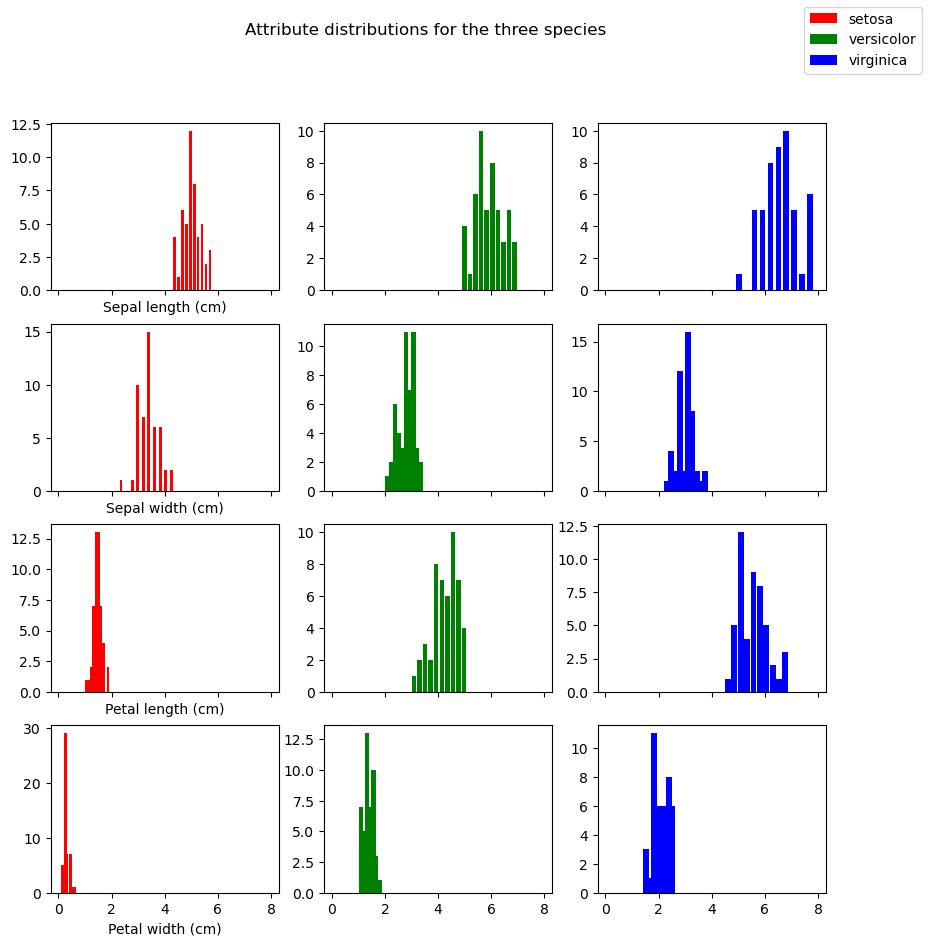

In [21]:
# We are doing a figure with 12 subplots (each subplot is called an axis).  Each is a histogram.
# We're arranging the histograms in 4 rows and 3 columns
(fig,axes) = plt.subplots(4,3,figsize=(10,10),sharex=True)

colors= ["r","g","b"]
# bar widths for the histograms, one for each soecies
widths = [.11,.17,.22]

# row refers to a row of histograms in the figure.
# For example The Sepal length histograms for the 3 species are in the first row of histograms
# Sepal length is an iris attribute, Those values are in column 0 in the iris `features` array
for row in range(4):
    # col is the display col; also the species
    for col in range(3):
        if row == 0:
            # For purposes of the legend, get the species name
            # We do this only for the first row, to prevent duplicate legends
            label=data['target_names'][col]
        else:
            label=None
        # one iris attribute in each display row.  Each iris attribute is a column in features
        # one species in each display col.  Each species is a subset of rows (target==col) in features
        axes[row,col].hist(features[target==col,row],width=widths[col],label=label,color=colors[col])
        if col == 0:
            # Display the attribute label on the x-axis only in the first column, to prevent clutter
            row_label= feature_names[row].capitalize()
            axes[row,col].set_xlabel(row_label)

fig.legend()
# No room for main title with tight layout
#fig.tight_layout()
fig.suptitle(f"Attribute distributions for the three species")

This conveys the fact that the same attribute can have differing distributions for
the three specifies (contrasting the 3 histograms in each row) but it doesn't
visually convey the idea that each plant (row in the features table) is a point
in a 4-dimensional space.  The problem with that idea is that it's impossible
to visualize.

## 3.  Plotting 2D Projections of the data

Let's try to approximate that by doing many pictures.
Study the pictures created by the code below.

Each of the 6 subplots features a pair of attributes.
For example, we pick **sepal length** amd **sepal width** in the first subplot.
We then represent each iris as
a point out on the 2D xy plane, using the sepal length as the x coordinate and
sepal width as the y-coordinate, and we color it according to its class. 
Each plot is a **scatter plot** of
all 150 data points using different **2D projections**. 
The 3 classes of iris are rendered as blue, green, and red
points of different shapes.  The idea is to
see if irises of of the same class cluster together based on the attributes
we're looking at.

The point is: each plot looks different from the others because each is a different
projection  of the same 4-dimensional data,  To help emphasize that point,
we've distinguished the example point P discussed
above, so that you can see how its representation changes from subplot to
subplot. Since P is of class 1, it has been drawn as a filled in green circle,
but it is much larger than the other green circles.  The contrasting
views of the data given in each projection can be observed
in the way P jumps around from plot to plot.

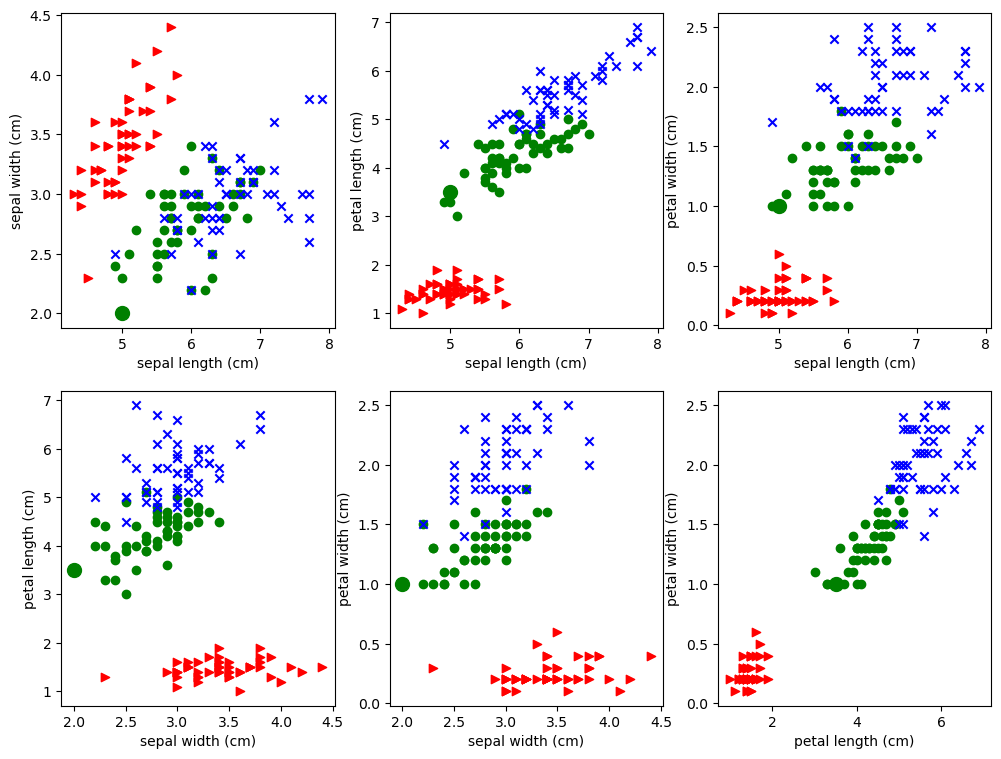

In [9]:
%matplotlib inline

import pylab 
import numpy as np
from matplotlib import pyplot as plt

markers, colors  = ">ox", "rgb"

# Display: We're doing 6 subplots arranged in a 2x3 grid.  Each subplot is called an axis.
# So: two rows axes, three axes in each row.
# We chose 6 subplots we could do all 6 possible pairings of of the 4 cols in features.
# To we define a 3D numpy array. pairs[i,j] is a pair (a 1D array of shape (2,))
# for example, pairs[1,2]  is np.array([2,3])
# np.array([2,3]) represents the two attributes we'll plot at axes[1,2] of our display (2nd row, 3rd col)
pairs = np.array([(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)]).reshape((2,3,2))
fig,axes = plt.subplots(2,3,figsize=(12,9))

# Let's keep track of a single point  P with attention-getting large SIZE.
# Row for point P, Class for point P
p_features,p_cls  = features[-90],target[-90]
# marker-shape and marker-color for P
p_marker,p_clr = markers[p_cls], colors[p_cls]

# 6 subplots in 2x3 configuration. Each subplot pairs two iris
# attributes we call x and y. 
for i,display_row in enumerate(pairs):
    for j,(x,y) in enumerate(display_row):
        # Get the axis object for this subplot.
        ax = axes[i,j]
        # On each subplot we're doing 3 sets of points, each belonging to a different iris class
        # with a different color and shape used to draw the points.  To do all 3 sets, use a loop.
        # To loop through 3 sequences at once, zip them together first
        for cls,marker,clr in zip(range(3),markers,colors):
            ax.scatter(features[target == cls,x], features[target == cls,y], marker=marker, c=clr)
        # Use large size marker (s=100) for the distinguished point P
        ax.scatter(p_features[x],p_features[y],marker=p_marker,c=p_clr,s=100)
        # Done with P
        
        # Label this subplot with the names of the two features being studied.
        ax.set_xlabel(feature_names[x])
        ax.set_ylabel(feature_names[y])
        # To make it prettier, uncomment the following & remove ticks on the x and y axis.
        #ax.set_xticks([])
        #ax.set_yticks([])

plt.savefig('iris_datasets_separations.png')

## 4.  Linear separation

Since this notebook as about classification, in particular, linear classification,
we're going to consider the problem of drawing straight lines to **separate** the classes.  First off the plots above clearly show that it's much easier to separate the red points from the blue and green points than it is to separate the blue points from the green points. As an example let's draw a pretty good line for separating the red points from the others for the second plot in
the first row.  This is the one that plots **sepal length** (x-axis) against **petal 
length** (y axis).  Note that I found the line by eyeballing the plot and using
trial and error.

Text(0, 0.5, 'petal length (cm)')

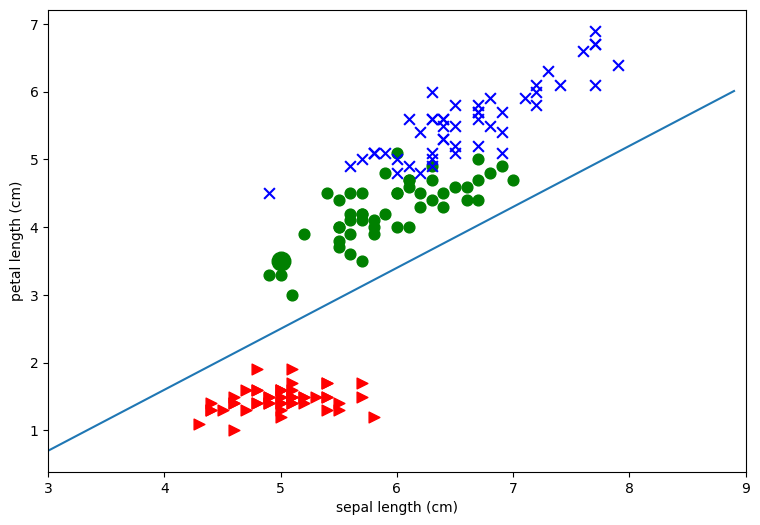

In [10]:
# After some trial & error, I decided on a line specified by the following 2 numbers worked.
# m is the slope, b is where the line intercepts the y axis (not seen in the figure)
(m,b) = (.9,-2)
# The indexes for the two iris features we're using for this plot.
(p0,p1) = (0,2)

fig,ax = plt.subplots(1,1,figsize=(9,6))
# Scatter the data points
for t,marker,c in zip(list(range(3)),">ox","rgb"):
    ax.scatter(features[target == t,p0], features[target == t,p1], 
                marker=marker, c=c,s=60) 

# Let's draw our point P with extra special attention getting large SIZE.
p_features,p_target  = features[-90],target[-90]
p_marker,p_clr = ">ox"[p_target], "rgb"[p_target]
plt.scatter(p_features[p0],p_features[p1],marker=p_marker,c=p_clr,s=180)
 
# Draw our classifier line
# We'll only draw the portion of the line relevant to the current figure.
(xmin,xmax) = (3.,9.)
# tighten the boundaries on the drawing to the same limits
#plt.gca().set_xlim(xmin,xmax)
ax.set_xlim(xmin,xmax)
#Between xmin and xmax, mark off a set of points on the x-axis .1 apart
xvec = np.arange(xmin,xmax,.1)
# Plot a stright line with the chosen slope & intercept
ax.plot(xvec,m*xvec+b)
ax.set_xlabel(feature_names[p0])
ax.set_ylabel(feature_names[p1])

To see what this line does,  consider our example iris P, which is the green class.

Let's pretend we don't know the class of P, but we do know
its attributes. So we know $P$ has sepal length 5 and petal length 3.5.  

Let's plot it and use our line as a classifier.

Text(0, 0.5, 'petal length (cm)')

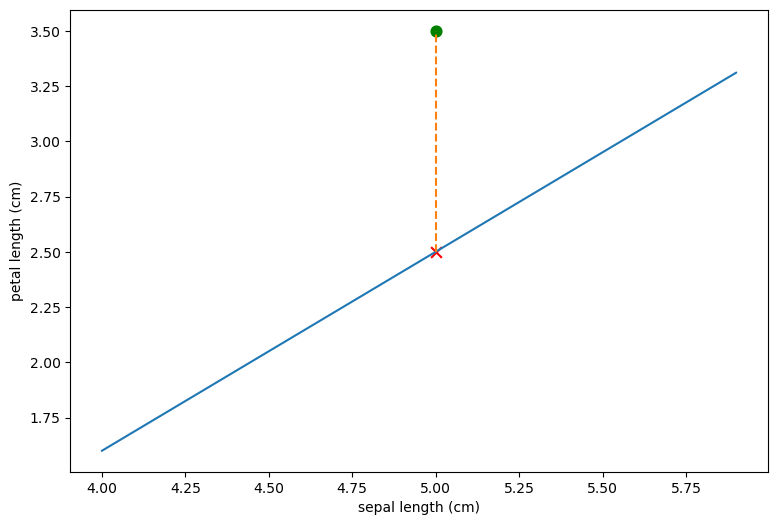

In [22]:
import numpy as np

# Our sample point
P = features[-90]
(xPrime,yPrime) = (P[0],P[2])
# Boundaries of what we'll draw.
(xmin,xmax) = (4.0,6.0)
# Ticks at which to place points on x- axis
xvec = np.arange(xmin,xmax,.1)
# our classifier line slope and intercept
(m,b) = (.9,-2)
#  Use (m,b) for the EQUATION of the classifier line.  
yvec = m*xvec+b

# Alternative way to set figsize
# pylab.rcParams['figure.figsize'] = (8.0, 6.0)
fig,ax = plt.subplots(1,1,figsize=(9,6))
# Plot the classifier line
ax.plot(xvec,yvec)

# Plot P at xPrime, yPrime
ax.scatter(xPrime,yPrime , marker='o', c='g',s=60) 
# y-value for the point on the line below P
yHat = m*xPrime + b

# Plot a point X below P, directly on the classifier line
plt.scatter([xPrime],[yHat] , marker='x', c='r',s=60) 
xvec2,yvec2 =np.array([xPrime,xPrime]),np.array([yHat,yPrime])
# Plot the dashed line from X to P
ax.plot(xvec2,yvec2,linestyle='--')
# Draw the frame around the plots TIGHT
ax.axis('tight')
ax.set_xlabel(feature_names[p0])
ax.set_ylabel(feature_names[p1])

The representation of the iris $P$ in this plotting system is shown as the green dot.  Since the
redpoints all fall below our lone and iris $P$ falls above it we would classify 
$P$ as a non-red class iris.  Also shown
(as a red X) is what the petal of length of $P$ would have to be for it to fall directly in the line.

Here is that point:

In [23]:
xPrime,yHat

(5.0, 2.5)

Basically for any iris
with sepal length 5, if it's petal length is greater than 2.5 we classify it as non-red;
if it's less than 2.5 we classify it as red.  The line defines a **classification rule**.

Moreover we can easily extend the rule to any sepal length.  In fact,
we can write a classification rule, using the equation for the line.  Let `(x',y')`
be the point to classify: We want to write a function that 
returns `True`  whenever `(x',y')` falls below the line
and `False` otherwise.


To do this we'll the definition of `yvec` (which determines the y-coordinates
of the blue line in the code above):

```
yvec = m*xvec+b
```

To get a point above the line `y'` to be greater than `m * x' + b`.  The numerical values of `m`
and `b` set in the code above are:

In [24]:
m,b

(0.9, -2)

So to classify a point as red, we want the following quantity to be negative:

```
y' - (.9x' - 2) = y' -.9x' + 2
```

Taking our example point :

In [25]:
xPrime, yPrime,

(5.0, 3.5)

In [26]:
yPrime - .9* xPrime + 2 

1.0

This is positive, which tells us the point falls above the line and should
be classified as non-red.

We have just applied a **classification rule**.  Next we write **a function that implements our rule**.

In [28]:
def is_red (P):
    """
    P is a data point, all 4 attributes.
    
    Return True if P is red.
    """
    return (P[2] - .9*P[0] + 2) < 0

P = features[-90]
print('P is red: {0}'.format(is_red(P)))

P is red: False


## 5.  Relationship to regression

How is what we've done related to regression, especially linear regression?

Well, first of all, in both the linear regression case and the linear discriminant case,
we are using numerical data (a scattering of points) to try to determine a line.

We are defining the line in different ways.  In the linear regression case, we looked 
for the best line to represent the scattering of points we saw. In the linear discrimination
case, we are looking for the best line to **separate** two classes.

Just as it wasn't always possible to find a line that was a good **fit** to our scattering of data, so it isn't always possible separate a scattering of points with a line.

What we're seeing in the plots above is that, taking the features by pairs, we can't see
a good way to separate all 3 classes.

We'll validate this intuition in the next section. We'll use a program that does a kind of linear discrimination; that is, it tries to find linear separations between classes.  Instead of using Fisher's method, which is called Linear Discriminant Analysis (LDA), we'll use
something called **Logistic regression**, which has become far more popular in many applications.  The differences don't matter for our purposes,  but logistic regression is much more likely to be the method of choice in linguistic applications. 

Note:  Scikit learn does have an implementation of linear discriminant analysis, should you
want to try Fisher's method.  It's called `LinearDiscriminantAnalysis`,
and it is in in `sklearn.discriminant_analysis`.

## 6.  Linear classifier results

We're going to use `sklearn` to build a linear classifier to to separate all three classes. We're first going to use just the sepal features, to keep it visualizable.  We'll use a type of linear classifier called  a **Logistic Regression classifier**.

Some code for plotting our results:

In [32]:
from sklearn import linear_model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib import pyplot as plt
import numpy as np

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    
    Dont worry too  much about this part of the code.  Meshes
    are a mesh-y topic.  They are the 2D version of aranges.
    xx and yy define a mesh: a rectangular region covering  all of
    the training data X.  xx contains the x coords, yy the y coords.
    xx[0,:] is the x coords of the first row of the rectangle.
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def show_classifier_separators (clf,X,y,xlabel=None,ylabel=None,title="Classifier separators",
                                figsize=(6,4),s=25, alpha=0.8, h=.02, ax=None,cmap=plt.cm.coolwarm,
                                outfile=None):
    """
    Assuming classifier is trained on X and X is 2D.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1,figsize=figsize)
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1, h=h)
    # Classify ALL the points in the meshgrid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap, alpha=alpha)
    # Note that the classes y are used as the color and will be interpreted
    # relative to the colormap.
    ax.scatter(X0, X1, c=y, cmap=cmap, s=s, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    # The numbers on the axes generally wont  mean much to us.
    ax.set_xticks(())
    ax.set_yticks(())
    title_obj = ax.set_title(title)
    if outfile is not None:
        plt.savefig(outfile)

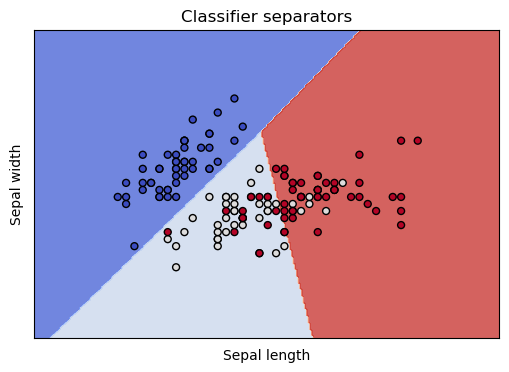

In [33]:


#  Use just the first 2 columns as predictors
#  Why?  So we can draw this!
X = features[:,:2]
Y = target


# we create an instance of a Logistic Regression Classifier.
lin = linear_model.LogisticRegression(C=1e5,solver='lbfgs',multi_class='auto')

# To try Fisher's method. You would need comment out the line above and uncomment this line.
#lin = LinearDiscriminantAnalysis()

# we fit the data.
lin.fit(X, Y)

show_classifier_separators (lin,X,Y,xlabel='Sepal length',ylabel='Sepal width')

The differently colored regions represent the areas the classifier has reserved for particular classes, and the dots are our training data, colored by species.  We see that all our worries are validated.  The classifier separates the class in the dark blue region nicely, and has trouble discriminating the points in the lightblue and red regions.  

This coloring also makes it clear that it's not 
really the classifier's problem: These two dimensions are insufficient to discriminate the three species. In the light blue and red regions, the light colored dots and the red colored dots
are thoroughly intermingled.  These are points from our training data, belonging to two different species,
but which nearly the same coordinates in these 2 dimensions. 
In other words, given just the sepal length and sepal width, there is no way to tell these
irises species apart.

Can we quantify what's going on? Certainly.

Here's how to find out our score.

In [53]:
from sklearn.metrics import accuracy_score
# Rerun prediction on just the training data.
X = features[:,:2]
Y = target
# we create an instance of a Logistic Regression Classifier.
logreg = linear_model.LogisticRegression(C=1e5,solver='lbfgs',multi_class='auto')
logreg.fit(X, Y)
predicted = logreg.predict(X)
# Y has the right answers.
print(f"{accuracy_score(Y,predicted):.1%}")

83.3%


#### We didn't do very well

Well, we went and cheated by evaluating our score on just the training data,
just as we said we **shouldn't**  do in the Simple Regression notebook,
and we **still** didn't do very well.  Only 80% correct!

Maybe our problem is that we keep using only two features at a time. What if we use **all**
the features at once?  Please note how simple the change in following code is. 

Let's use all 4 features.  Compare the definition of X used in the cell above.

```
X = features[:,:2]
```

In [34]:
X = features
y = target
lin = linear_model.LogisticRegression(C=1e5, solver='lbfgs',multi_class='auto')
#Uncomment to try Fisher's method
#lin = LinearDiscriminantAnalysis()
lin.fit(X, Y)
predicted = lin.predict(X)
accuracy_score(Y,predicted)

0.9866666666666667

Yep,  that was our problem.  Our accuracy is now 98%! 

And so we pause for a moment to take in one of the central lessons of multivariate statistics.  Using more variables can help.  Bigtime.  As we saw in the simple regression notebook, it doesn't always help; but as long
as we're getting new independent information that isn't just noise from the new features, it's worth
trying.

We started out essentially asking the question, what linear function of two 
of these variables can best separate these classes?  And we tried all possible systems using two features and didn't do very well.  But then we switched to asking what linear function
of all 4 variables can best separate these variables? And we did **much** better.

So why didn't we do this to start with?  And why did the code get so much simpler?

Second question, first, because the two answers are related.  The code got much simpler
because we threw out the visualization code.  And we threw out the visualization code
because we switched to a system that was much harder to visualize.  We essentially went from representing our code in 2 dimensions (so that 
we could plot every point on an the xy plane) to representing it in 4 dimensions.
Try and visualize 4 dimensions!  Pretty hard.  And that's the answer
to the first question.  We didn't do it this way to start with because
we wanted something we could visualize, and that proved helpful, because there
were insights the visualizations gave us, especially about the red class.

And therein lies one problem with switching to 4 dimensions.  We've lost our capacity
to glean insights from the data, at least with the tools we've looked at till now.
We don't really know what relationships got us over the hump in classifying
irises.

So lesson number one is that more variables can help.  And lesson number
two is that there are perils involved in using more variables.  Actually 
we haven't even scratched the surface of the many perils involved in higher-dimensional
data, but we've identified an important one.  Using more variables makes things
more complicated, and that makes it harder to understand what's going on.
At some point we are going to have turn around and explain our results
to an audience waiting with baited breath, and you have be **very** careful when explaining
multivariate results.  Visualization is a big help at explaining complicated
relationships, so losing the ability to visualize is not a small loss,
especially since what real life problems often involve is not yes/no classifications,
but insight.  More on the problem of visualizing higher-dimensional data later in
the course.

In the meantime, to try to recover a little insight into what is going on with
a completely visualizable representation of the iris data, have a look at the appendix.

## Evaluating a classifier: General ideas

There is a problem in what we've done so far.  The classifier is doing a good job at identifying
species, but what if it's succeeding by identifying accidental features
of particular irises?  In other words, suppose it's learning something like this:
An iris with these measurements:

In [63]:
X[0,:]

array([5.1, 3.5, 1.4, 0.2])

belongs to species 0?

In [64]:
target[0]

0

We know it's not doing exactly that because we've restricted it to a linear model, but
the general form of the worry remains.   In general, after training a classifier,
we want to know how well it's done at learning useful generalizations about the class
or classes of interest, and we can't really evaluate how well a classifier has learned the generalizations
that distinguish iris species until we test it on data it hasn't seen during training.

#### Training/test split

That leads us to the idea of a **training/test split**.  Let's re-evaluate our 4-feature classifier
by training it on part of the data and testing it on entirely unseen data; scikit learn makes this
pretty easy:

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=47)

In [36]:
lin = linear_model.LogisticRegression(C=1e5, solver='liblinear',multi_class='auto')
#Uncomment to try Fisher's method
#lin = LinearDiscriminantAnalysis()
lin.fit(X_train, y_train)
predicted = lin.predict(X_test)

# Evaluate
accuracy_score(y_test,predicted)

0.9666666666666667

The results actually improved!

How is that possible?  Well, possibly the test set did not include any of the difficult examples
that reduced the score when evaluating on the entire data set.  

One way to fix this is to evaluate multiple times; if we remove the random state argument, each time we execute 
the training/test split we get a different random split of the entire data set into training
and test subsets.  So let's do that multiple times, and train and test
multiple times, and look at the results:

In [37]:
for i in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    lin = linear_model.LogisticRegression(C=1e5, solver='liblinear',multi_class='auto')
    lin.fit(X_train, y_train)
    predicted = lin.predict(X_test)

    # Evaluate
    print(f"{accuracy_score(y_test,predicted):>6.1%}",
          )

 90.0%
 86.7%
 96.7%
 86.7%
100.0%
 96.7%
 96.7%
 90.0%
 96.7%
100.0%


On the assignment you may be asked to do a training test split when evaluating a classifier.
That means you should use scikit learn's `train_test_split` function called in line 3 of the code
above.  If asked to do multiple train/test splits, you should write
a loop like the one above  that does a complete evaluation in the body of the
loop, so that multiple train/test splits are evaluated.

Ultimately, of course, you will want to boil the results down to single numbers for each
evaluation measure.  That means computing the average accuracy over the 10 runs,
and the average precision and recall, when using those evaluation measures.  That has not been done here.

## 7. PCA as classifier

Here is a different version of the same picture we drew in Section 3 of this notebook, the Iris data projected onto its first two dimensions:

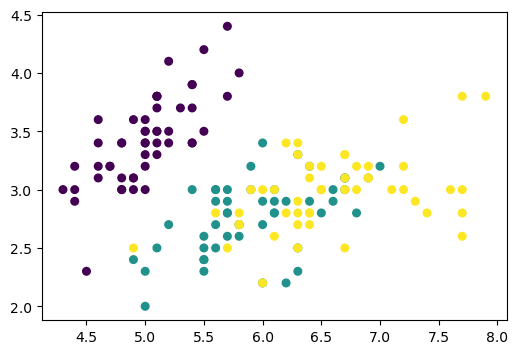

In [5]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.svm import LinearSVC

data = load_iris()
X = data['data']
feature_names = data['feature_names']
y = data['target']
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(X[:, 0], X[:, 1], c=y,
       #s=30, cmap=plt.cm.coolwarm)
        s=30, cmap=plt.cm.viridis)

Now we apply PCA dimensionality reduction, yielding another 2D representation,
and draw a picture of that.

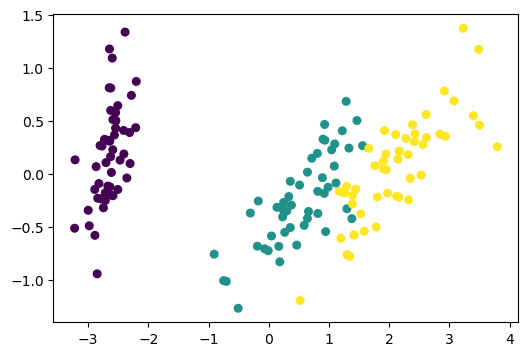

In [16]:
from sklearn import decomposition as dec
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = data['data']
y = data['target']

reducer = dec.PCA(n_components=2)
# Scaling the data hurts classification
#reducer = make_pipeline(StandardScaler(), dec.PCA(n_components=2))
X_reduced_pca = reducer.fit_transform(X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y,
       s=30, cmap=plt.cm.viridis)

Note that this 2D picture looks quite different from the previous
2D picture (and the other pictures we drew in Section 3 of this notebook).

The previous 2D picture only uses information from 2 of the 4 dimensions,
so what it represents is a projection of the 4D data into 2 of the given dimensions.
As we saw in Section 3 of this notebook, the distance relationships
for our 4D data can change dramatically depending on which 2D projection
we use.  

What distinguishes the PCA representation is that it is **not**
a projection onto previously existing axes.  Instead
we have created two new orthogonal axes  which
define a new latent space and do the the best 
job of explaining the variance.  The picture above is drawn in the latent space.

Note the data in the latent space  won't always heighten the contrast between
classes.  PCA loses information and, since it is trained without labels,
it has no way of knowing which information is relevant to a particular classififcation
task. But it is worth trying with when little information is lost
and there is good reason to suspect the classes are linearly separable.

Now what shall we do next?  

Build a classifier, of course, using our "Principled" 2D
representation.  

Note:  This is not a new classification method.  We're using the same
same classifier we used before, just training it on a 
different representation of the data.

PCA Reduction plus Logistic Regression

In [17]:
lin_pca_r = linear_model.LogisticRegression(C=1e5, solver='lbfgs',multi_class='auto')
lin_pca_r.fit(X_reduced_pca, y)
predicted = lin_pca_r.predict(X_reduced_pca)
print(accuracy_score(y,predicted))
print(recall_score(y,predicted,average=None))
precision_score(y,predicted,average=None)

0.9733333333333334
[1.   0.96 0.96]


array([1.  , 0.96, 0.96])

Plain old Logistic Regression

In [17]:
lin_pca = linear_model.LogisticRegression(C=1e5, solver='lbfgs',multi_class='auto')
#X_unreduced = reducer.inverse_transform(X_reduced)
lin_pca.fit(X, y)
predicted = lin_pca.predict(X)
print(accuracy_score(y,predicted))
print(recall_score(y,predicted,average=None))
precision_score(y,predicted,average=None)

0.9866666666666667
[1.   0.98 0.98]


array([1.  , 0.98, 0.98])

So based on this evaluation over all the training data,
the PCA accuracy is not quite as good as our full 4-feature 
model but still a lot better than the 83.3% accuracy we got with the 2-feature model
in Section 6 of this notebook, where we trained a classifer
on the first two columns of the data (for a fuller picture, computing correct evaluation results for all
6 2-feature projections, follow the instructions in the assignment notebook).

Here is the same kind of picture we drew for the Section 6 classifier. With that 2D representation, we
saw two of the classes were thoroughly intermingled.  With the PCA 2D
representation, in contrast, as we just saw, the classes have a great deal of separation,
and this picture shows how easily the classifier finds linear separators
that partition all three classes, which is what lies behind its 97% accuracy score.

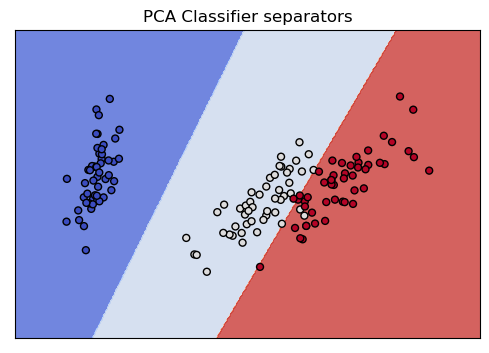

In [18]:
cmap= plt.cm.coolwarm
show_classifier_separators (lin_pca_r,X_reduced,y,title="PCA Classifier separators",cmap=cmap,
                            outfile="PCA_separators.png")

#### Linear Discriminant Analysis (another form of Dimensionality Reduction)

Principal Component Analysis (PCA) tries to find the combination of attributes (principal components) that account for the most variance in the data. 

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance **between** classes. That means LDA, unlike PCA, is a **supervised** reduction method: it requires known class labels in order to train.

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lda = LDA(n_components=2)
#lda = make_pipeline(StandardScaler(), LDA(n_components=2))

In [26]:
X_reduced_lda = lda.fit_transform(X,y)
predicted = lda.predict(X)
print(accuracy_score(y,predicted))

0.98


Text(0.5, 1.0, 'PCA')

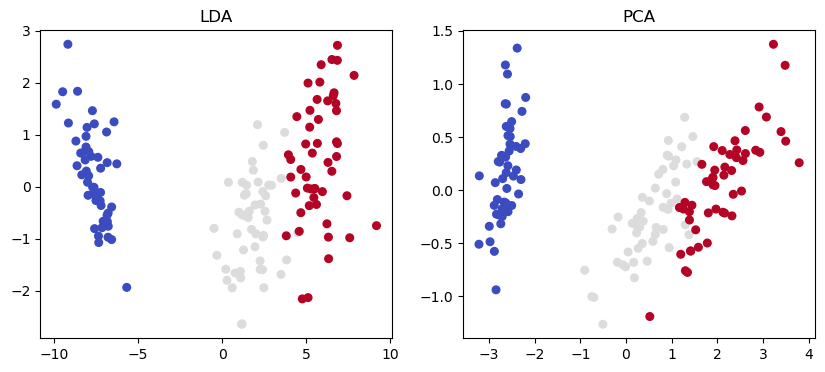

In [27]:
from sklearn import decomposition as dec
X = data['data']
y = data['target']

cmap = plt.cm.coolwarm
#cmap=plt.cm.viridis
reducer = dec.PCA(n_components=2)
# PCA offers the option of supervised reduction, like LDA
X_reduced_pca = reducer.fit_transform(X,y)

fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(10, 4))
# The two plots look a bit like mirror images reflected on (approx) the y-axis
# Try multiplying X_reduced_lda[:, 0] by -1.
ax0.scatter(-1 * X_reduced_lda[:, 0], X_reduced_lda[:, 1], c=y,
       s=30, cmap=cmap)
ax0.set_title("LDA")
ax1.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=y,
       s=30, cmap=cmap)
ax1.set_title("PCA")

#### Methodology


Let's confirm the difference between LDA and PCA  using multiple train/test runs.

We'll test four different classifiers:

1. PCA Reduction (using Logistic Regression to classify)
2. LDA Reduction (using LDA's internal algorithm to classify)
3. LDA Reduction to create a 2D representationm of the data, chosen to best reduce the variance between
   classes, followed by classification by Logistic Regression  on the 2D LDA data.
4. Logistic Regression plain and simple, trained and tested without reduction.

In [28]:
from sklearn.model_selection import train_test_split

def multiple_runs_reducer(X,y,num_runs,reducer,supervised_reduction=False,
                         use_reducer_as_clf=True,verbose=True):
    accs = np.zeros(num_runs)
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=i)
        #reducer = dec.PCA(n_components=2)
        #X_train_reduced = reducer.fit_transform(X_train)
        if supervised:
            X_train_reduced = reducer.fit_transform(X_train,y_train)
        elif reducer is not None:
            X_train_reduced = reducer.fit_transform(X_train)
        else:
            X_train_reduced = X_train
        # Use the transform method of the trained reducer on the test data
        # No fitting allowed on test data
        if reducer is not None:
            X_test_reduced = reducer.transform(X_test)
        else:
            X_test_reduced = X_test
        if supervised and use_reducer_as_clf:
           clf= reducer
        else:
           clf = linear_model.LogisticRegression(C=1e5, solver='liblinear',multi_class='auto')
        clf.fit(X_train_reduced, y_train)
        try:
            predicted = clf.predict(X_test_reduced)
        except AttributeError:
            clf = linear_model.LogisticRegression(C=1e5, solver='liblinear',multi_class='auto')
            clf.fit(X_train_reduced, y_train)
            predicted = clf.predict(X_test_reduced)
        acc = accuracy_score(y_test,predicted)
        accs[i] = acc
        # Evaluate
        print(f"{acc:>6.1%}")
    return accs


num_runs=10
for (rdr, reducer, supervised) in [("PCA",dec.PCA,False), ("LDA", LDA, True), ("LogReg",None, False)]:
    if reducer:
        reducer_inst = reducer(n_components=2)
    else:
        reducer_inst = reducer
    if rdr == "PCA":
        use_reducer_as_clf=False
    elif supervised:
        use_reducer_as_clf=True
    accs = multiple_runs_reducer(X,y,num_runs,reducer=reducer_inst,supervised_reduction=supervised,
                                use_reducer_as_clf=use_reducer_as_clf)
    print(f"\n{rdr:<20} {(accs.sum()/num_runs):>6.1%}",end="\n\n")  
    if supervised:
        accs2 = multiple_runs_reducer(X,y,num_runs,reducer=reducer(n_components=2),supervised_reduction=supervised,
                                      use_reducer_as_clf=False)
        print(f"\n{rdr+'+LogReg':<20} {(accs2.sum()/num_runs):>6.1%}",end="\n\n")  

100.0%
 96.7%
 96.7%
 96.7%
 93.3%
 96.7%
 96.7%
 86.7%
 90.0%
100.0%

PCA                   95.3%

100.0%
100.0%
100.0%
100.0%
 93.3%
 93.3%
100.0%
 96.7%
 96.7%
100.0%

LDA                   98.0%

100.0%
100.0%
100.0%
100.0%
 93.3%
 93.3%
100.0%
 86.7%
 93.3%
100.0%

LDA+LogReg            96.7%

100.0%
 96.7%
 96.7%
100.0%
 93.3%
 93.3%
 96.7%
 83.3%
 90.0%
100.0%

LogReg                95.0%



So according to accuracy, and evaluation using multiple train/test  LDA using its own internal classifier algorithm was the best classifier, and LDA + Logistic Regression came in second. 

So that contradicts what we got when we evaluated on all the training data.

####  Dimensionality reduction using Kernel PCA with the  RBF kernel

Just for fun here's another dimensionality reduction technique, kernel reduction using
an RBF kernel.

For this one, if you want to be able to invert the transformation, you have
to sign up for that from the outset:

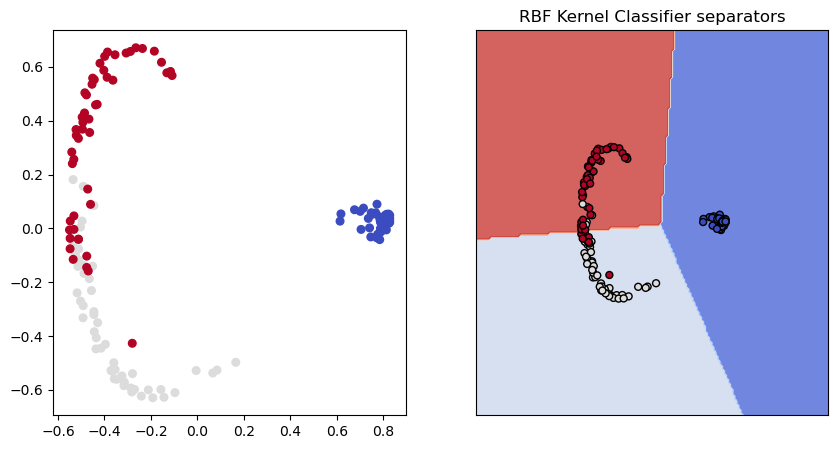

In [37]:
ker_reducer = dec.KernelPCA(kernel='rbf',n_components=2,fit_inverse_transform=True)
X_ker = ker_reducer.fit_transform(X)
lin_ker = linear_model.LogisticRegression(C=1e5, solver='liblinear',multi_class='auto')
lin_ker.fit(X_ker, y)
(fig, (ax1,ax2)) = plt.subplots(1,2,figsize=(10,5))
cmap=plt.cm.coolwarm
#fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax1.scatter(X_ker[:, 0], X_ker[:, 1], c=y, s=30, cmap=cmap)
show_classifier_separators (lin_ker,X_ker,y,title="RBF Kernel Classifier separators",ax=ax2,cmap=cmap)

In [130]:
num_runs=10
accs_rbf = multiple_runs_reducer(X,y,num_runs,reducer=dec.KernelPCA(kernel='rbf'))

100.0%
 96.7%
 96.7%
 86.7%
 93.3%
 90.0%
 93.3%
 83.3%
 86.7%
 93.3%


In [133]:
accs_rbf.sum()/num_runs

0.9200000000000002

The reduction does not seem to help in the sense that average 
is worse than we got for plain old Logistic Regression  with no reduction.

Despite the good classifier performance, the RBF reduction
certainly **looks** like a very different picture of the
data from the PCA model.  Perhaps more information was lost?

In [39]:
import scipy

def information_lost(X, X_reduced, transformer):
    """
    Meaasure the amount of information lost by the transformer.
    
    Reverse the transformation and look at the difference matrix gotten
    by subtracting X_reduced reverse-transformed from X. In the ideal
    case of no information lost this difference should be 0.
    
    Compare the frobenius norm  (a kind of length
    measure for matrices) of the difference matrix to the frobenius norm of X.
    """
    return scipy.linalg.norm(X - transformer.inverse_transform(X_reduced),ord="fro")

information_lost(X, X_ker, ker_reducer)

7.643157412636098

Yes, but not much more.  Way better than our two random axes. 
The RBF reducer reverse transforms almost as well as the PCA reducer does.

A final note on PCA.  Using PCA to aid with classification tasks is a classic application.
In doing that, we are usually less interested in the component vectors themselves
than in how well the representations they produce perform in the classification task.  Obviously, as suggested
by the pictures above, visualization is another application of that sort.  A third example would be Principle Component Regression (PCR), where regression is done on the principle components instead of the original
variables to help with issues like multicollinearity.

In other applications of PCA, such as financial analysis,
the weights in the component vectors themselves may be of interest,
because they help us take further analytical steps
to find predictive patterns in the original data.

#### Assignment note

Note:  For the homework assignment you will use the numpy arrays representation of the data.

To experiment with different sets of features you will need
to be able to concatenate the  columns of the
dataset that are appropriate to each experiment.

If you are unfamiliar with numpy array concatenation you may want to take a look at the optional 
[numpy_array_concatenation notebook](https://colab.research.google.com/github/gawron/python-for-social-science/blob/master/text_classification/numpy_array_concatenation.ipynb) for a brief overview of the relevant functions.

### Appendix A:  End to End Classification example:  Recognizing adjectives

This appendix is an end to end example of training and evaluating a classifier, from
collecting and preparing data to training the classifier to evaluating it.

The succeeding appendices continue continue to use this example, discussing various
ways to evaluate classifiers.

We train a  classifier to recognize adjectives just by their word shape, inspired
by little word clusters like the following:

```
curious
odious
ruinous
heinous
```

or 

```
possible
miserable
doable
bankable
visible
````

or 

```
baggy
squishy
funky
briny
spikey
```

or 

```
salient
extant
constant
divergent
urgent
important
```

Our goal is to build a classifier that can recognize a word as an adjective without ever having seen it before.

The idea is that there are recognizable patterns in the word shapes of adjectives,
and this example demonstrates that some very simple models can learn them.

We will need to train our classifier on a large word set, and test it on
unseen words.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

#### Preparing the data

Import some word data containing part of speech information:

Adam Kilgariff's British National Corpus (BNC) word list,
which is tagged with parts of speech.


In [43]:
fn="https://www.kilgarriff.co.uk/BNClists/all.num.o5"
#word_df = pd.read_csv(fn,index_col=1,sep=" ", names=["Freq","POS", "DocFreq"])
word_df = pd.read_csv(fn,sep=" ", names=["Freq","Word", "POS", "DocFreq"])

In [44]:
punct = r"\?\+_!\.@\$%\^&\*\(\)=\[\]{}#<>`~'\",/\|~:;"
digits = "01234567890"


def isword (wd):
    """
    Let's filter out a host of nonwords.
    """
    if not isinstance(wd,str):
        return False
    if wd.startswith("-"):
        return False
    for char in punct:
        if char in wd:
            return False
    for char in digits:
        if char in wd:
            return False
    return True

In [45]:
# More efficient way using regexps
import re

def construct_forbidden_chars_reg_exp_string (punct,digits):
    illegal_chars_re_list = []
    buff = ""
    # Parse the escape character ("\") correctly in order to
    # create correct list of forbidden characters
    for char in punct+digits:
        if char == "\\":
           buff += char
           continue
        illegal_chars_re_list.append(buff + char)
        buff = ""
    # In addition to all the forbidden characters
    # tack on the restriction that a word cant begin with a hyphen ("-")
    return "^-|" + ('|'.join(illegal_chars_re_list))

illegal_re = construct_forbidden_chars_reg_exp_string (punct,digits)
illegal_re_c= re.compile(illegal_re)

ex_list = []

def isword_regexp(wd):
    global ex_list
    if not isinstance(wd,str):
        #raise Exception("Non string in isword_regexp")
        return False
    if isword(wd) and bool(illegal_re_c.search(wd)):
        ex_list.append(wd)
    return not bool(illegal_re_c.search(wd))

In [46]:
print(len(word_df))
word_df0 = word_df[word_df["Word"].apply(isword_regexp)]
#ni = word_df.index.intersection([wd for wd in word_df.index if isword(wd)])
print(len(word_df0))
#word_df = word_df.loc[ni]
#print(len(word_df))

208657
190245


In [47]:
word_df.head()

,Freq,Word,POS,DocFreq
0,100106029,!!WHOLE_CORPUS,!!ANY,4124
1,6187267,the,at0,4120
2,2941444,of,prf,4108
3,2682863,and,cjc,4120
4,2126369,a,at0,4113


In [48]:
print(len(word_df))
word_df = word_df[word_df["Word"].apply(isword)]
# Equivalently
#word_df = word_df[word_df["Word"].apply(isword_regexp)]
print(len(word_df))

208657
190245


In [49]:
# word_df is already sorted by freq.  
# By default Drop duplicate keep the first entry, meaning the most frequent
# pos entry
word_df_filtered  = word_df.drop_duplicates(subset=['Word'])
len(word_df),len(word_df_filtered)

(190245, 113982)

Compare original and filtered dfs for an example word:

In [50]:
example_word = "right"
example_word_freq = word_df_filtered[word_df_filtered["Word"]== example_word]["Freq"].values[0]
word_df[word_df["Word"]== example_word]

,Freq,Word,POS,DocFreq
277,31638,right,av0,2785
398,22835,right,aj0,2758
792,11946,right,aj0-nn1,2390
965,9981,right,nn1,2255
1811,5645,right,aj0-av0,1599
3348,2952,right,nn0,1301
3775,2562,right,itj,632
47219,72,right,np0,34


In [51]:
word_df_filtered[word_df_filtered["Word"]== example_word]

,Freq,Word,POS,DocFreq
277,31638,right,av0,2785


With duplicate entries for words removed it is now convenient to use the word column as the index:

In [52]:
word_df_filtered = word_df_filtered.set_index("Word")

Look up the example word row to exhibit the effect of `.set_index()`.

In [53]:
word_df_filtered[word_df_filtered["Freq"]==example_word_freq]

,Freq,POS,DocFreq
Word,,,
right,31638,av0,2785


To look up a word now we use the index; every index value will uniquely identify a single row,
because of how we created the index.

In [13]:
print(example_word)
word_df_filtered.loc[example_word]

right


Freq       31638
POS          av0
DocFreq     2785
Name: right, dtype: object

In [54]:
word_df_filtered.loc["fight"]

Freq       3171
POS         vvi
DocFreq    1194
Name: fight, dtype: object

####  Preparing the classifier training set

Separate adjectives from non adjectives

In [57]:
adj_pos_list = ["aj0",'ajc','ajs','aj0-nn1']
adj_bool = word_df_filtered["POS"].isin(adj_pos_list)
adj_vocab = list(word_df_filtered[adj_bool].index)
adj_vocab = [(a,1) for a in adj_vocab if isword(a)]
other_vocab = list(word_df_filtered[~adj_bool].index)
other_vocab = [(x,0) for x in other_vocab if isword(x)]

In [81]:
'unready' in word_df_filtered[~adj_bool].index

False

In [58]:
len(adj_vocab),len(other_vocab)

(19606, 94376)

In [84]:
adj_vocab[:15]

[('other', 1),
 ('new', 1),
 ('good', 1),
 ('old', 1),
 ('different', 1),
 ('local', 1),
 ('small', 1),
 ('great', 1),
 ('social', 1),
 ('important', 1),
 ('national', 1),
 ('british', 1),
 ('possible', 1),
 ('large', 1),
 ('young', 1)]

In [85]:
other_vocab[:15]

[('the', 0),
 ('of', 0),
 ('and', 0),
 ('a', 0),
 ('in', 0),
 ('to', 0),
 ('it', 0),
 ('is', 0),
 ('was', 0),
 ('i', 0),
 ('for', 0),
 ('you', 0),
 ('he', 0),
 ('be', 0),
 ('with', 0)]

#### Represent the data numerically; split into train and test data


In [59]:
# CountVectorizer:  Read the CountVectorizer docs to learn about the diff between analyzer char and char_wb.
# As an example, with bigram features: analyzer char_wb given "Mark" will yield "k " 
# as a feat and for analyzer char the corresponding feature will be "k".  Essentially
# char_wb pads peripheral chars, thereby introducing word boundary information.
# Since feat "a " means "a" as the last letter, this representation allows the clf to learn
# last letter "a" as a part-of-speech cue.

#cv = CountVectorizer(ngram_range=(1,2),analyzer='char_wb')
#cv = CountVectorizer(ngram_range=(2,3),analyzer='char_wb')
cv = CountVectorizer(ngram_range=(2,4),analyzer='char_wb')
#cv = TfidfVectorizer(ngram_range=(2,4),analyzer='char_wb')

data = adj_vocab + other_vocab
# A sequence of strings; a sequence of labels
words, tags = zip(*data)

X_train, X_test, y_train, y_test = \
  train_test_split(words, tags, test_size=0.05, random_state=42)

##  Train it to learn a fixed set of features
X_train_m = cv.fit_transform(X_train)

## Now useonly those features on the test set (no more fitting)
X_test_m = cv.transform(X_test)

The count vectorizer after training:

In [60]:
len(cv.get_feature_names_out())

78716

Some sample features:

In [61]:
for ft in cv.get_feature_names_out()[2000:2005]:
    print(ft)

 fik
 fil
 fim
 fin
 fio


We show the feature names and feature values for the word `"alfalfa"`:

In [62]:
from collections import Counter

idx2wd = cv.get_feature_names_out()

def get_word_features(wd,ct_dict=False):
    m = cv.transform([wd])
    w_vec = np.array(m.todense()[0,:][0])[0]
    feats = w_vec.argsort()
    i = -1
    # after this loop, |i\ is the number of feats turned on.
    while w_vec[feats[i]]:
        i-=1
    if ct_dict:
        return {idx2wd[ft]:w_vec[ft] for ft in feats[i+1:]}
    else:
        return sorted(idx2wd[feats[i+1:]])

In [63]:
get_word_features("alfalfa",ct_dict=True)

{'falf': 1,
 ' al': 1,
 'lfa ': 1,
 'a ': 1,
 'lfal': 1,
 ' a': 1,
 'fa ': 1,
 ' alf': 1,
 'fal': 1,
 'alf': 2,
 'lfa': 2,
 'al': 2,
 'lf': 2,
 'alfa': 2,
 'fa': 2}

The training set (`X_train`) has this many "documents" (= words).

In [64]:
len(X_train)

108282

The transformed document set (`X_train_m`) is a 2D numpy array: num_training_words x num_features.

In [92]:
X_train_m.shape

(108282, 78716)

The first "document" (=word):

In [65]:
X_train_array = X_train_m.todense()
first_doc=X_train_array[0,:]

In [94]:
first_doc.max(),first_doc.min()

(1, 0)

Approximately how many "features" (out of the 78K features)  are turned on in the first document?
(this will possibly overestimate, if some features have a count greater than 1):

In [95]:
first_doc.sum()

15

####  Training the classifier (Logistic Regression)

In [66]:
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train_m, y_train)

# Test
y_predicted = clf.predict(X_test_m)

# Optional but convenient below
y_test = np.array(y_test)
accuracy_score(y_predicted,y_test)

0.9329824561403509

This Accuracy score is not as impressive as it looks at first.

Note the percentage of non adjectives is:

In [97]:
1- (sum(y_train)/len(y_train))

0.8281801222733234

And slightly lower in the test set:

In [98]:
1- sum(y_test)/len(y_test)

0.8243859649122807

which means one can achieve an accuracy of over 82% by always guessing nonAdj.

####  Evaluation Discussion

The following principle is quite general:

>Accuracy is an unreliable measure of classifier performance when the classes are unbalanced.

Our classes are unbalanced here because only about 15% of the words are adjectives.  A somewhat more informative evaluation is the following informal one, which cherry picks a number of tricky and not so tricky words from the test set.


In [69]:
endings = ["ous","est","y","ant","ous","ary","ble","al","ive"]

def has_a_ending (wd):
    if wd.endswith("ly"):
        return False
    for end in endings:
        if wd.endswith(end):
            return True
    return False

# Not so tricky.  Has known adj ending and is an adj
interesting_test_0 = [x  for (i,x) in enumerate(X_test) if has_a_ending(x) and y_test[i]==1]
# tricky.  Has known adj ending and is not an adj
interesting_test_1 = [x  for (i,x) in enumerate(X_test) if has_a_ending(x) and y_test[i]==0]
# tricky 2.  Has no known adj ending and is an adj
interesting_test_2 = [x  for (i,x) in enumerate(X_test) if not has_a_ending(x) and y_test[i]==1]

In [70]:
test_size =100
test2 = cv.transform(interesting_test_0[:test_size])
test3 = cv.transform(interesting_test_1[:test_size])
test4 = cv.transform(interesting_test_2[:test_size])
ps2 = clf.predict(test2)
ps3 = clf.predict(test3)
ps4 = clf.predict(test4)
print(accuracy_score(ps2,[True for i in range(test_size)]))
print(accuracy_score(ps3,[False for i in range(test_size)]))
print(accuracy_score(ps4,[True for i in range(test_size)]))

0.85
0.83
0.72


Here are the ones we got wrong on each test:

In [71]:
start=50
#  Things we thought weren't adjs that were
[interesting_test_0[i] for i in range(start,test_size) if ps2[i]==0]

['popery',
 'bosky',
 'expectant',
 'arrogant',
 'glittery',
 'pricey',
 'referral',
 'motley']

In [117]:
# Things we thought were adjs that weren't
[interesting_test_1[i] for i in range(start,test_size) if ps3[i]==1]

['lowery',
 'austria-hungary',
 'somerwest',
 'ual',
 'vegetable',
 'besant',
 'denial',
 'chantal',
 'four-thirty',
 'celebrant',
 'marky']

In [118]:
#  More things we thought weren't adjs that were
[interesting_test_2[i] for i in range(start,test_size) if ps4[i]==0]

['burgeoning',
 'varied',
 'bated',
 'abbreviated',
 'crystalline',
 'laurentian',
 'extinct',
 'bizarre',
 'show-off']

There are a number of important regularities our classifier hasn't learned, some about
endings that are likely to belong ot adjectives, some about endings that are likely **not**
to belong to adjectives.

### Appendix B :   Accuracy, Precision, and Recall

This next section takes the first few steps toward evaluatng a classifier a little more seriously.  It uses
some standard  evaluation metrics for  classifier output.  The evaluation metrics defined are precision, recall, and accuracy.  Call the examples the system **predicts** to be positive (whether correctly or not) ppos and and the examples it predicts to be negative pneg; consider the following performance on 100 examples:


$$\begin{array}[t]{ccc} &  pos &neg\\ ppos& 31 & 5\\ pneg & 14 & 50 \end{array}$$


This kind of breakdown of a classier's performance on test data is called
a **confusion matrix**.  In a 2-class confusion matrix, a classifier's results are sorted into 4 
groups:


$$\begin{array}[t]{ccc} &  pos &neg\\ ppos& tp & fp\\ pneg & fn & tn \end{array}$$


The $tp$ and $tn$ examples (true positive and true negative) are those the system labeled correctly,
while $fp$ and $fn$ (false positive and false negative) are those labeled incorrectly.
Let N stand for the total number of examples,
100 in our case. 

The three most important measures of system performance are:
  
  1. **Accuracy**: Accuracy is the percentage of correctly classified examples out of the total corpus 

  $$\text{Acc} = \frac{tp+tn}{N} = \frac{31 +50}{100}$$ 
  
  This is .81 in our case.

  2. **Precision**: Precision is the percentage of true positives out of all positive predictions the system made 
  
  $$\text{Prec}=\frac{tp}{pp} = = \frac{tp}{tp + fp} =  \frac{31}{31+5}.$$
  
  This is .86 in our case.  Precision is sometimes called **positive predictive value**.
  
  3. **Recall**: Recall is the percentage of the actual positives that were identified by the system (often called the True Positive Rate):
  
  $$\text{Rec} = \text{TPR}  = \frac{tp}{p} = \frac{tp}{tp + fn} = \frac{31}{31+14}.$$
  
  This is .69 in our case. Recall is sometimes called **sensitivity** or **hit rate**. It can be described as the probability that a relevant instance will be tagged as relevant.
  
  A major motivation for defining Precision and Recall is that they give us useful measures of classifier performance when the data is unbalanced, as it is for adjective recognition.  
  
  Precision and Recall were just defined with respect to the positive class;
  they can just as usefully be defined for the negative class.  Precision for the negative class means: 
  what proportion of the time that the system predicts something to be negative is it truly negative. That
  is:
  
 3. **Precision for Negative class**: Precision for the negative class is the percentage of true negatives out of all negative predictions the system made 
  
  $$\text{Neg Prec}=\frac{tn}{pn} = = \frac{tn}{tn + fn} =  \frac{50}{50+14}.$$
  
  This is .78 in our case.  Precision for the 
  negative class is sometimes called **negative predictive value**.
  
  4. **Recall for the Negative class**: Recall for the negative class is the percentage of 
  the total number of negatives that were identified by the system:
  
  $$\text{Neg Rec} = \text{TNR}  = \frac{tn}{n} = \frac{tn}{tn + fp} = \frac{50}{50+5}.$$
  
  This is .91 in our case. Recall for the negative class can be described as the probability that a negative instance will be tagged as negative.
  
  
  There are also important evaluation metrics that measure how **bad** a system is (higher is worse):
  
  5.  **False Negative Rate**:  

  $$ \text{FNR} = \frac{fn}{tp + fn} = \frac{31}{31+14} = 1 - \text{Rec} $$
  
  6. **False Positive Rate** (used in computing AUC score below)
  
   $$ \text{FPR} = \frac{fp}{fp + tn} = \frac{31}{31+14} = 1 - \text{TNR} $$
   
Finally, accuracy,  precision and recall can all be defined meaningfully in a multiclass setting
(like the 3-class problem posed by the iris data).  Accuracy is still the number
right divided by the total number of examples; for precision and recall, there are 3 different
recall scores and 3 different precision scores.  It simply
needs to be made clear which class precision and recall are being measured for,
as we did, for example, when we defined precision for the negative class.

Here for illustration purposes is an example of a 3-class confusion matrix:


$$\begin{array}[t]{cccc} 
                   &  \text{Class A} & \text{Class B}& \text{Class C}\\ 
\text{predicted A} & 21              & 5             &    10           \\ 
\text{predicted B} & 9              & 20            &    13           \\
\text{predicted C} & 5              &  10             &   7              \\
\end{array}$$

The Accuracy of this system is the number
correct divided by the total number of examples:

$$ \text{Accuracy} = \frac{ 21 + 20 + 7}{100} = .48 $$

Let's illustrate class-relative precison and accuracy with
respect to Class A. For example,  precision for Class A is
the number of correct predictions for Class A divided
by the total number of class A predictions:

 $$ \text{Precision for Class A} = \frac{21}{21 + 5 + 10} =.58 $$
  
  
Recall for Class A is the number of correct predictions for Class A divided
by the total number of class A instances:

 $$ \text{Recall for Class A} = \frac{21}{21 + 9 + 5}= .60 $$


In our example we have two classes we can evaluate performance on, adjective and non-adjective.   That is, we can ask how good a job are we doing at predicting that a word is an adjective purely from its
form and we can ask how good a job are we doing at predicting that a word is a non-adjective purely from its
form.

Let's illustrate using the logistic regression results we got above,  where the only evaluation we used was accuracy.

In [119]:
from sklearn.metrics import precision_score, accuracy_score, f1_score

# Eval metrics
precision_a = precision_score(y_test,y_predicted)
recall_a = recall_score(y_test,y_predicted)
precision_o = precision_score(y_test,y_predicted,pos_label=0)
recall_o = recall_score(y_test,y_predicted,pos_label=0)

print(f"Precision(adj): {precision_a:.2f} Recall(adj): {recall_a:.2f}")
print(f"Precision(non): {precision_o:.2f} Recall(non): {recall_o:.2f}")

Precision(adj): 0.83 Recall(adj): 0.77
Precision(non): 0.95 Recall(non): 0.97


And as we might expect from the **way** our data is unbalanced, we do a much better job
of predicting that something is a non-adjective.

Here is the confusion matrix that yields those results.

In [120]:
###         | ppos    pneg
### ------------------------------
###   pos   |  tp       fn 
###   neg   |  fp       tn

#array([[ 182,  122],
#     [  56, 2140]])

cm = confusion_matrix(y_test,y_predicted,labels=[1,0])
cm

array([[ 772,  229],
       [ 153, 4546]])

Display can be facilitated using pandas, with color optionally added (you may need to re-execute the
code cell below to get the colors to display properly).

In [121]:
import pandas as pd
cm_df = pd.DataFrame(cm,columns = ('ppos','pneg'),index=('pos','neg'))
cm_df.style.background_gradient(cmap='Blues')

,ppos,pneg
pos,772,229
neg,153,4546


For example, what percentage of the positives did we predict to be positive (what percentage of the first row did we get right)?

$$
772/(772+229)  = tp/(tp + fn)
$$


What evaluation number is that?  Precision or recall?  For which class, adj or non-adj?

To directly compute evaluation scores in confusion
matrix format, we can **normalize** the confusion matrix,
and there are two ways to do that, by row and by column.

For example, rowwise normalization does the sort of computation we just did for the positive class.
The numbers in the rows add up to 1.

In [124]:
cm_n = confusion_matrix(y_test,y_predicted,normalize='true',labels=[1,0])
cm_n_df = pd.DataFrame(cm_n,columns = ('ppos','pneg'),index=('pos','neg'))
#cmap=plt.cm.Blues,
cm_n_df.style.background_gradient(cmap='Blues')

,ppos,pneg
pos,0.771229,0.228771
neg,0.032560,0.967440


Next we try normalizing the confusion matrix above by column:

$$
772/(772 + 153) = tp/(tp + fp)
$$

This computes what percentage of our positive predictions were true positives.

So is that value recall or precision?

In [125]:
772/(772+153)

0.8345945945945946

The complete column-normalized confusion  matrix, where the columns add up to 1:

In [126]:
from sklearn.metrics import confusion_matrix

cm_n = confusion_matrix(y_test,y_predicted,normalize='pred',labels=[1,0])
cm_n_df = pd.DataFrame(cm_n,columns = ('ppos','pneg'),index=('pos','neg'))
cm_n_df.style.background_gradient(cmap='Blues')

,ppos,pneg
pos,0.834595,0.047958
neg,0.165405,0.952042


Exercise:  Using the data above, and the train-test split above, train other classifier types.

Here are some numbers I got.  Yours probably won't agree, but they shouldnt be to far off.

#### Results

Multinomial NB

```
Precision(adj): 0.58 Recall(adj): 0.61
Precision(non): 0.95 Recall(non): 0.94
```

Ridge

```
Precision(adj): 0.71 Recall(adj): 0.62
Precision(non): 0.95 Recall(non): 0.96
```

Log. Regr:

```
Precision(adj): 0.83 Recall(adj): 0.70
Precision(non): 0.95 Recall(non): 0.97
```

### Discrimination threshholds

The classifier we've been mostly using up till now, Logistic Regression, is a probabilistic classifier.  That means 
it makes all its classification decisions by assigning a probability for each class to
each test instance.

The default **decision rule** for logistic regression: if the probability of the positive class is
greater than .5 for test instance $i$, classify $i$ as positive.

We call .5 the **discrimination threshhold value** or just the **threshhold value**

We illustrate the idea using our adjective classifier.  Here are the probabilities for 10 est examples:

In [127]:
##  Set print to ffloat format precision = 3
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_prob = clf.predict_proba(X_test_m)
y_prob[40:50,1]

array([0.027, 0.075, 0.029, 0.032, 0.   , 0.97 , 0.001, 0.991, 0.125,
       0.831])

And here are the corresponding classifications (the 3 cases with probabilities greater than .5 have
been classified as adjectives).

In [128]:
y_predicted = clf.predict(X_test_m)
y_predicted[40:50]

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 1])

Now let's try implementing a new decision rule. We'll lower the discrimination threshhold.  

In [129]:
def predict_with_prob_threshhold(clf, threshhold=.5):
    y_prob = clf.predict_proba(X_test_m)
    return y_prob[:,1] >= threshhold

If we lower the threshhold to .4, more instances will be classified as **positive**.

In [130]:

y_predicted1 = predict_with_prob_threshhold(clf, threshhold=.4)

print(y_predicted.sum(), y_predicted1.sum())
print(y_predicted1.sum() - y_predicted.sum())

925 998
73


With the default threshhold, 925 instances are classified as adjectives; with the lowered threshhold
998 test words are declared adjectives, a difference of 73.

So the number of instances classified as positive went up.

With more instances classified as positive, what happens to **recall** (true positive rate)?


$$\text{Rec} = \text{TPR}  = \frac{tp}{p}= \frac{tp}{tp + fn}.$$

Recall 

```
a. must go up.
b. may go up.
c. must remain the same.
d. must go down.
e. may go down.
```

Answer below

The answer is [b]; recall may go up.

The denominator is going to remain constant (we didn't change `y_test`);
the numerator can't go down (all the previous positive predictions remained
positive, so [d] and [e] are out), but it might go up, since
we might hit on a few more true positives
as we're letting more positives in.  Since the numerator might go up,
recall might go up, so [a] AND [c] are out. 

What happens to recall for the adjective classifier when we lower the threshhold?

In [131]:
recall1_a = recall_score(y_test,y_predicted1)

print(f"Recall(adj): {recall_a:.2f}; Recall with .4 threshhold: {recall1_a:.2f}")

Recall(adj): 0.77; Recall with .4 threshhold: 0.80


It goes up, even though it didn't have to.  That means we lowered the trheshhold enough
to let some new true positives in.

What happens to precision in general when the threshhold is lowered?

$$Prec= \frac{tp}{pp}= \frac{tp}{tp + fp}.$$

We're very likely to change $pp$; that could involve increasing $tp$ but in general 
there will also be a risk of increasing $fp$, so both the numerator and denominator
could increase.

The change in precision depends on the specific numbers, and very specifically on how much the
false positive rate goes up.

In our system

In [132]:
# Original scores
precision_a = precision_score(y_test,y_predicted)
recall_a = recall_score(y_test,y_predicted)

print(f"Precision(adj): {precision_a:.2f} Recall(adj): {recall_a:.2f}")

Precision(adj): 0.83 Recall(adj): 0.77


In [133]:
precision1_a = precision_score(y_test,y_predicted1)
recall1_a = recall_score(y_test,y_predicted1)


In [134]:
precision1_a = precision_score(y_test,y_predicted1)
print(f"Precision(adj): {precision_a:.2f}; Precision with .4 threshhold: {precision1_a:.2f}")

Precision(adj): 0.83; Precision with .4 threshhold: 0.80


So precision went down.

Let's look at different hypothetical cases:

No fp increase (every additional pp is a tp) $\longrightarrow$ Precision goes up:

In [23]:
1/4, 2/5,3/6,4/7

(0.25, 0.4, 0.5, 0.5714285714285714)

But mostly this is what happens.  We gain tps at the cost of more fps.  Precision goes down.

In [24]:
1/4, 2/8,2/9,2/10

(0.25, 0.25, 0.2222222222222222, 0.2)

Mathematically, precision may go up, may stay the same, or may go **down** as the threshhold lowers,
but in practice, lowering the threshhold  will sooner or later run out of true positives,
and as the number of false positives increases with little or no increase 
in true positives, precision goes down.

In the plot below we plot the effect of changing the probability threshhold
for both precision and recall on our adjective classifier.

The picture produced is a classic case of the precision recall trade-off:
in general as we lower the threshhold for being called an adjective,
reacll will increase and precision will go down.

In [138]:
from matplotlib import pyplot as plt

def precision_recall_tradeoff(add_f1_score=False,figsize=(7,4),verbose=False):
    threshholds = np.linspace(0.01, .90, 100)
    predictions = np.array([predict_with_prob_threshhold(clf, threshhold=threshhold) 
                            for threshhold in threshholds])
    if verbose:
        print(y_test.shape)
    # E.G., 100 threshhold values, 5700 predictions for each
    if verbose:
        print(predictions.shape)
    prec_scores =\
        np.apply_along_axis(lambda y_pred:precision_score(y_test, y_pred), 1, predictions)
    rec_scores =\
        np.apply_along_axis(lambda y_pred:recall_score(y_test, y_pred), 1, predictions)
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.plot(threshholds, prec_scores, label="precision")
    ax.plot(threshholds, rec_scores, label="recall")
    if add_f1_score:
        f1_scores= np.apply_along_axis(lambda y_pred:f1_score(y_test, y_pred), 1, predictions)
        ax.plot(threshholds, f1_scores, label="f1")
        f1_str = "F1 score"
    else:
        f1_str = ""
    ax.set_title(f"Precision Recall {f1_str} for Adj Detection")
    ax.set_xlabel("P-threshhold")
    plt.legend(loc="lower center")

(5700,)
(100, 5700)


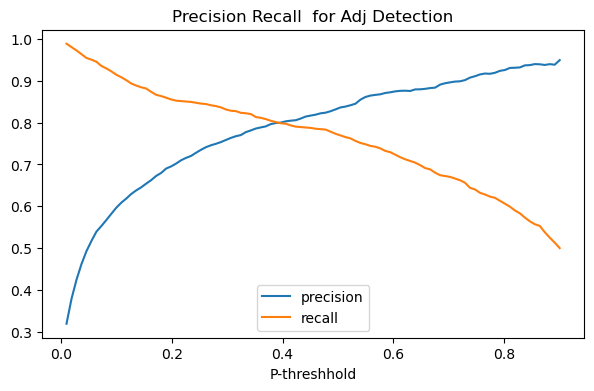

In [139]:
precision_recall_tradeoff(verbose=True)

### F1-Score: A single number combining precision and recall

The picture above is captioned "Precision Recall Tradeoff", the idea being that we can increase
precision at the expense of recall, or vice versa.  From this viewpoint classifier performance is inherently
two dimensional.  We decide which dimension we want to favor based on the application,
and optimize that, or we decide both are equally important.  If we believe that,
then it's possible to combine the two into a single score which is penalized
whenever either precision or recall suffers, and which is at its maximum at the
crossing point in the picture above. The most natural way to define such a combined score is called `f1_score`, which is the harmonic mean of precision and recall (harmonic means are appropriate for taking
averages of **rates**).

Adding that to our picture, we get the green arch, which peaks at the point which best
honors both precision and recall.  For our classifier that's achieved by setting the
probability threshhold to around .35.

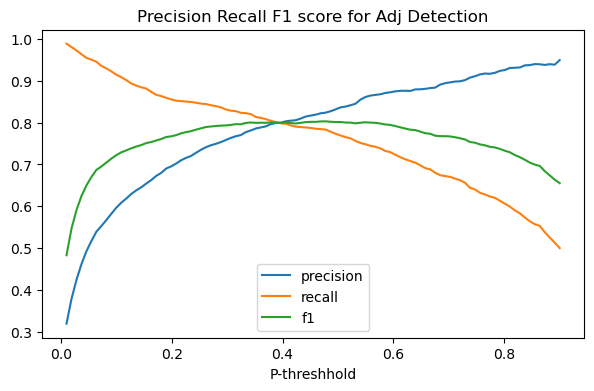

In [140]:
precision_recall_tradeoff(add_f1_score=True)

### Appendix C:  AUC score

We are going to try take advantage of the following idea.  Lowering the threshhold increases
the number of positive predictions.  In general, more true positives comes only at the
cost of more false positives.  But the lower the  cost for a given
number of true positives, the better the classifier. Of course a classifier
may perform poorly at low threshholds and then make up for that at high threshholds,
so we want a methodology that lets us look at the entire range of threshholds.
This leads us to something called **AUC score**.  AUC stands for area under the curve.


In this section we'll do some comparisons between systems.
So let's start out by defining the plotting function we need
and a dictionary containing instances of various classifier types.

In [141]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score,f1_score
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

clfs = {"Logistic Regression": LogisticRegression(solver='liblinear'),
        "Ridge Classifier":   RidgeClassifier(solver='sparse_cg'),
        "Multinomial NB" : MultinomialNB(),
        #"Passive Aggressive Classifier": PassiveAggressiveClassifier(loss="squared_hinge")
        "Passive Aggressive Classifier": PassiveAggressiveClassifier(loss="hinge")
       }


class_of_interest, pos_lbl = 'Adj',1

def do_auc_plot (classifier, y_test, y_scores, pos_lbl, class_of_interest, color="darkorange"):
    
    RocCurveDisplay.from_predictions(
        y_test,
        y_scores, # probs for the class of interest
        name=f"{class_of_interest}",
        color=color
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    #score_str = f"AUC: {roc_auc_score(y_test, y_scores_1D):.3f}"
    #plt.title(f"ROC curve {clf_name}: {score_str}")
    plt.title(f"ROC curve {clf_name}")
    plt.legend()
    
    

Initialize the dictionary that will hold our **evaluation results**.

In [142]:
auc_scores = {clf:0  for clf in clfs.keys()}

For purposes of this discussion, let's call recall by the other
name it has in the literature, **the true positive rate**  (the number of
true positives relative to the number of positives).  So a true positive
rate (or recall) of 1.0  means detecting all the positives that there are out
there.  Contrasting with that we'll look at the
**false positive rate**, which is the rate of false positives
relative to the number of negatives.  Here lower is good,
and more false negatives are okay as long as there are a lot of negatives out there.

To drill down and look at the precision
recall trade-off a little more closely we're going to look
at the underlying cause:  how increasing
the true positive rate affects the false positive rate.

In particular, we'll look at what's called the **ROC**.
ROC stands for **Receiver Operating Characteristic** (understanding
the name involves a little historical context we'll skip for now).  

ROC is  a classifier-specific function which returns
the true positive rate $t$ a classifier achieves
for any given level of false positive rate (FPR) $f$
as the discrimination threshhold is relaxed.  Generally, adjusting the threshhold to
reach a higher level of $p$ is achieved only at the cost of 
a higher rate of $f$, so 
plotting the function, we get something like the orange plot below,
which arcs above the line $p=f$, which has also been drawn.
The plot shown is for Logistic Regression's performance
on the adjective detection problem.

The line $p=f$ defines random performance.   A classifier that can add only one true positive
for each false positive has no  power to discriminate
among the new predicted-positive instances.
On the other hand, if, as the number of positives
increases, a classifier
sustains a high ratio of true positives
to false positives, that means it has 
strong discriminative power. Visually
that means the slope of its ROC curve 
will start out high.  Eventually even a strongly discriminative  classifier 
begins running out of true positives, so that most of the remaining
cases will be false positives; therefore the slope must decrease at some
point, as the slope of the orange curve does.

The orange line is actually a pictiure of pretty good
system by the AUC measure.  But imagine an even
better one, which achieved a TPR of 1 while
maintaining an FPR of 0, meaning perfect recall matched with perfect precision: ideal performance.
The "curve" would includes the top left corner of the plot.
In practice, no classifier acheives that performance;
but the closer the curve of the ROC function
gets to passing through that point, the better
the classifier.  More mathematically,
the greater the **area of the curve** describing the 
ROC function, the better the classifier.

An AUC score of .5 is the area
under the $p=f$-line, which signals
random performance.  
An AUC score of 1 denotes the area
inside the square with corners at $(0,0)$ and $(1,1)$, 
which signals perfect performance.  
So AUC scores will vary from .5 to 1.0.
The key idea here is that is a  way of evaluating
classifiers which doesn't take any particular
stand on how the precision/recall 
trade-off should be managed: The AUC score
depends on the entire path of the curve.

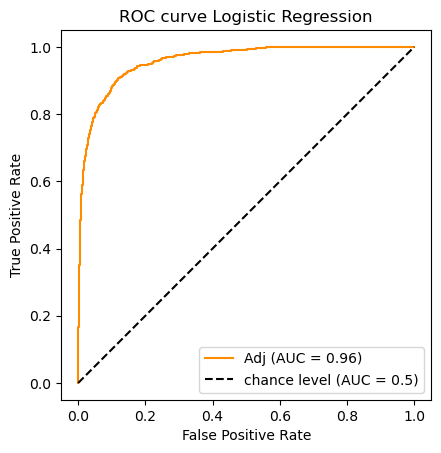

In [46]:
clf_name = 'Logistic Regression'
classifier = clfs[clf_name]
y_scores = classifier.fit(X_train_m, y_train).predict_proba(X_test_m)[:,1]
#  This gives log probs
#y_scores0 = classifier.fit(X_train_m, y_train).decision_function(X_test_m)#[:,1]
auc_scores[clf_name] = (classifier.predict(X_test_m),roc_auc_score(y_test, y_scores))
do_auc_plot (classifier, y_test, y_scores, 1, 'Adj')

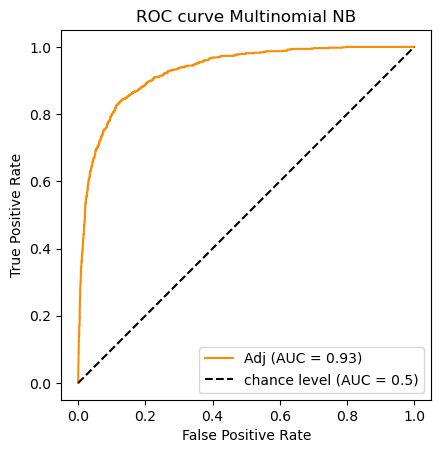

In [47]:
clf_name = 'Multinomial NB'
classifier = clfs[clf_name]
y_scores = classifier.fit(X_train_m, y_train).predict_proba(X_test_m)[:,1]
auc_scores[clf_name] = (classifier.predict(X_test_m),roc_auc_score(y_test, y_scores))
do_auc_plot (classifier, y_test, y_scores, 1, 'Adj')

Note that not all classifiers are probability-based; therefore not all will have a `predict_proba` method.

The *Ridge Classifier* is a variety of Support Vector Machine (SVM); the learning objective
is to find a hyperplane separating positive from
negative examples that maximizes the **margin** (the distance between the plane
and the nearest examples).  In place of `predict_proba` the Ridge Classifier
has a `decision_function` method
which returns confidence scores for each sample:

>The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.

In other words, the further a point is  away from the separating plane, the more
confident the classifier is about a positive/negative decision.  The AUC score
can be just as easily computed with a sequence of confidence scores as it is
with a sequence of probabilities.

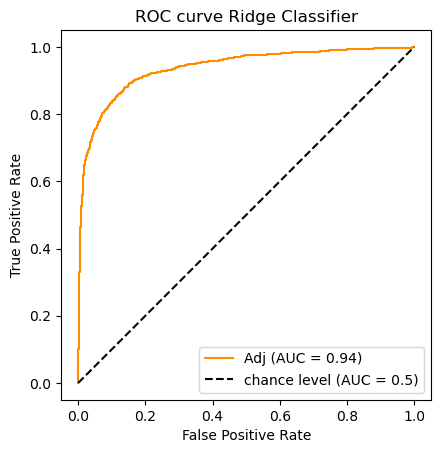

In [48]:
clf_name = 'Ridge Classifier'
classifier = clfs[clf_name]
#  Note The ridge classifier does not assign probabilities.
#  But it does compute scores available from its decision function
y_scores = classifier.fit(X_train_m, y_train).decision_function(X_test_m)
# For each classifier we store its predictions as well as its AUC score
auc_scores[clf_name] = (classifier.predict(X_test_m),roc_auc_score(y_test, y_scores))
# A picture is worth 1_000 words
do_auc_plot (classifier, y_test, y_scores, 1, 'Adj')

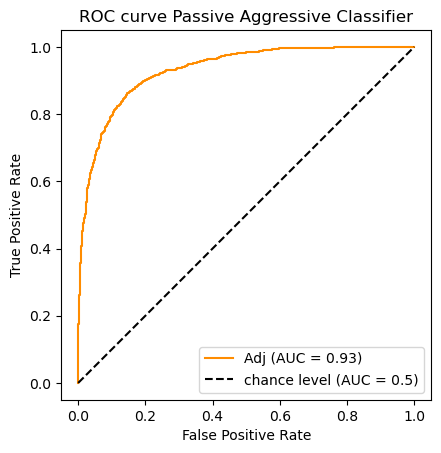

In [49]:
clf_name = 'Passive Aggressive Classifier'
classifier = clfs[clf_name]
y_scores = classifier.fit(X_train_m, y_train).decision_function(X_test_m)#[:,1]
auc_scores[clf_name] = (classifier.predict(X_test_m),roc_auc_score(y_test, y_scores))
do_auc_plot (classifier, y_test, y_scores, 1, 'Adj')

Reviewing the AUC numbers we got:

In [50]:
auc_scores.keys()

dict_keys(['Logistic Regression', 'Ridge Classifier', 'Multinomial NB', 'Passive Aggressive Classifier'])

In [51]:
[auc_scores[k][1] for k in auc_scores]

[0.9594033151659511, 0.9374223079099382, 0.928727980603359, 0.9315689148752219]

So according to the AUC metric the classifiers rank as follows:

$$
\begin{array}[t]{llc}
& \text{Classifier} & \text{AUC}\\ 
\hline 
1. & \text{Logistic Regression} & .959\\ 
2. & \text{Ridge Classifier} & .937 \\ 
3. & \text{Passive Aggressive Classifier} & .932 \\
3. & \text{Multinomial Naive Bayes}& .929
\end{array}
$$



### Appendix D:  An evaluation experiment

Another evaluation loop.  There are actually  a lot of classifiers concealed under the
name `SGDClassifier`.  SGD refers to a learning method (Stochastic Gradient Descent).
By folding different "loss" functions (learner scoring functions) into the algorithm
you get different kinds of linear learners; `log_loss` gets you a logistic regression
classifier; `hinge` gets you a classic SVM; `perceptron` is another loss function
defining a different kind of linear learner called a **perceptron**. Say the docs

>The other losses, ‘squared_error’, ‘huber’, ‘epsilon_insensitive’ and ‘squared_epsilon_insensitive’ are designed for regression but can be useful in classification as well; see [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressorfor) a description.

The brief experiment below illustrates the idea of evaluating multiple learners on a fixed problem,
alhough we are completely avoiding the important issue of cross-validation, which will be discussed
when we get to text classification.

You can see "squared error" does the worst, but it also fails to converge on a model.
As for the best,  it depends on your criteria.  If recall is the most important
thing, the regression method modifed huber does best, if it's precision, you want logistic regression.
Note that the recall score on this logistic regression classifier is not as good
as the one we got above with sklearn's `LogisticRegression` classifier (.70), which
used the `liblinear` learner.  It's not at all clear why, since this is the same training
and test set.

In [214]:
from  sklearn.linear_model import SGDClassifier

loss_fns = ("hinge", "log_loss",  "modified_huber", 
            "perceptron", "huber", "epsilon_insensitive", 
            "squared_error", )

auc_scores2 = dict()

for fn in loss_fns:
    clf_name = f'SGD Classifier {fn}'
    print(clf_name)
    classifier = SGDClassifier(loss=fn)
    y_scores = classifier.fit(X_train_m, y_train).decision_function(X_test_m)
    y_predicted = classifier.predict(X_test_m)
    auc = roc_auc_score(y_test, y_scores)
    rec =  recall_score(y_test,y_predicted)
    prec =  precision_score(y_test,y_predicted)
    auc_scores2[clf_name] = (y_scores,auc,rec,prec)
    #do_auc_plot (classifier, y_test, y_scores, 1, 'Adj')

SGD Classifier hinge
SGD Classifier log_loss
SGD Classifier modified_huber
SGD Classifier perceptron
SGD Classifier huber
SGD Classifier epsilon_insensitive
SGD Classifier squared_error


/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [219]:
banner = f"{'Classifier':<31}  AUC    Rec   Prec"
print(banner)
print("="* len(banner))

il = list(auc_scores2.items())
il.sort(key = lambda x:x[1][1], reverse=True)

for (clf, (y_scores, auc,rec,prec)) in il:
    print(f"{clf[15:]:<30} {auc:.3f}  {rec:.3f}  {prec:.3f}")

Classifier                       AUC    Rec   Prec
log_loss                       0.959  0.670  0.856
hinge                          0.953  0.692  0.853
modified_huber                 0.952  0.717  0.809
perceptron                     0.943  0.720  0.738
huber                          0.925  0.470  0.860
epsilon_insensitive            0.919  0.597  0.842
squared_error                  0.563  0.459  0.168


Alternatively we may fill out the evaluation with F1-score instead of
AUC score:

In [206]:
banner = f"{'Classifier':<40}   Rec    Prec  F1-Sc"
print(banner)
print("="* len(banner))

for (clf,(y_predicted,_auc)) in auc_scores.items():
    rec = recall_score(y_test,y_predicted)
    prec = precision_score(y_test,y_predicted)
    f_sc = f1_score(y_test,y_predicted)
    print(f"{clf:<40}  {rec:.3f}  {prec:.3f}  {f_sc:.3f}")

Classifier                                 Rec    Prec  F1-Sc
Logistic Regression                       0.701  0.830  0.760
Ridge Classifier                          0.687  0.809  0.743
Multinomial NB                            0.771  0.611  0.682
Passive Aggressive Classifier             0.663  0.753  0.705


What is the winner on each evaluation?

### Appendix E:  Working with confusion matrixes

The confusion matrix we used in the section entitled of Precision, Recall and Accuracy was displaying
classifier decisions in a two-class problem.  The kiond of information displayed can be even more
illuminating on a multiclass problem, and scikit learn provides some
helpful tools to do that.  We illustrate with the Iris data using [this scikit learn
demonstration.](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

By the way, this sort of color-enhanced numerical table display can also be done 
via pandas using `df.style.background_gradient(cmap=cmap)`, as we
did in Precision, Recall and Accuracy section.

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


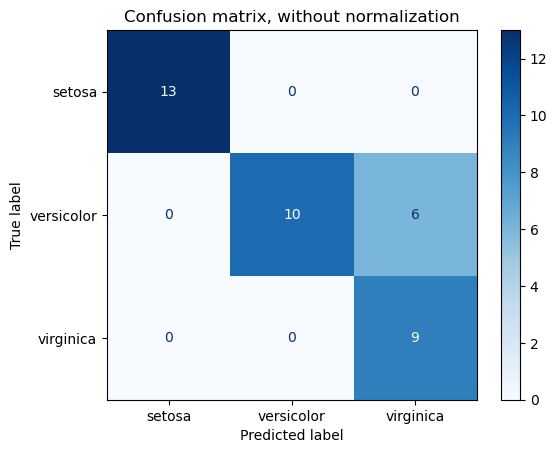

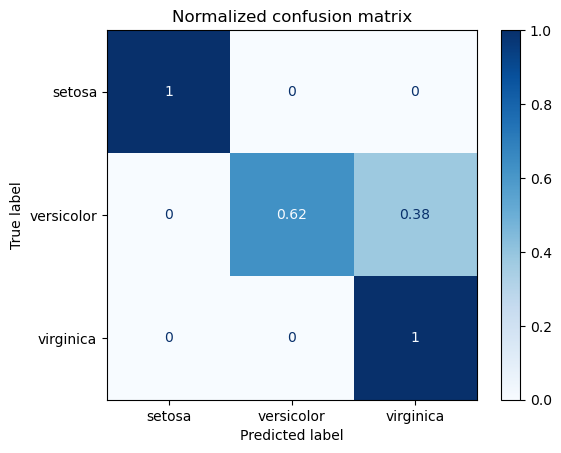

In [552]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel="linear", C=0.01).fit(X_train, y_train)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


It can be seen that the difficulty is in discriminating versicolor from virginica; moreover if the system 
predicts versicolor it is always right; the problems are that it is somewhat over-predicting virginica.

A less graphically snazzy way to do the 3 class confusion matrix:

In [553]:
from sklearn.metrics import multilabel_confusion_matrix

y_predicted = classifier.predict(X_test)
M = multilabel_confusion_matrix(y_test,y_predicted)
M

array([[[25,  0],
        [ 0, 13]],

       [[22,  0],
        [ 6, 10]],

       [[23,  6],
        [ 0,  9]]])

In [13]:
M.shape

(3, 2, 2)

### Appendix F: Using different types of Classifiers

Up until now every attempt we've made at classifying the iris data has used the same classifier,
Logistic Regression.   In this section we visualize the results of using other classifiers.
Actual evaluation of the classifiers is left as an exercise.

The plot below show 4 different Support Vector Machine (SVM) models
trained on the first two dimensions of the iris data.
We do a deeper dive into the consequences of using different types of Support Vector Machines (SVMs) in another notebook (`linear_classifier_svm`).

Here our chief goal is to provide some sample code for how to explore the behavior
of different classifiers  in `scikit_learn`.

Note: In the figure below, there are two plots labeled *SVC with Linear Kernal* 
and *Linear SVC*  (Linear kernel).  I believe these are just two different
implementations of what is mathematically the same model.  The similarities
in the plots support this view.  The SVC with RBF 
kernel and the SVC with polynomial kernel are mathematically different from Linear SVC
and from each other,
and you can see that in the  kinds of separators they learn.

In [37]:
from sklearn import svm, datasets

def compare_classifiers(X,y, models, titles, xlabel="", ylabel=""):
    """
    Assumption.  X is 2D.
    """

    predictions = (clf.fit(X, y) for clf in models)

    # Set-up 2x2 grid for plotting.
    fig, sub = plt.subplots(2, 2, figsize=(12,8))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    for clf, title, ax in zip(predictions, titles, sub.flatten()):
        show_classifier_separators (clf,X, y, title=title, ax=ax,xlabel=xlabel,ylabel=ylabel)
        
# import some data to play with
iris = datasets.load_iris()
# Take the first twofeatures. 
X = iris.data[:, :2]
xlabel, ylabel = iris.feature_names[:2]
y = iris.target

C = 1.0  # SVM regularization parameter

models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))

titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

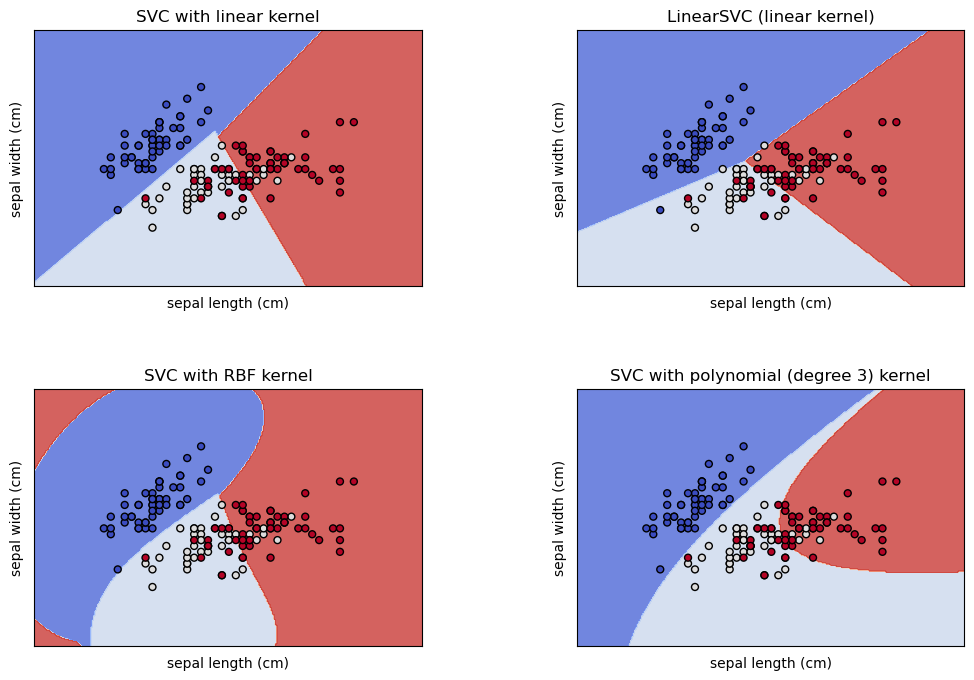

In [38]:
compare_classifiers(X,y, models, titles, xlabel=xlabel, ylabel=ylabel)

The same classifiers trained on an RBF Kernel reduction:

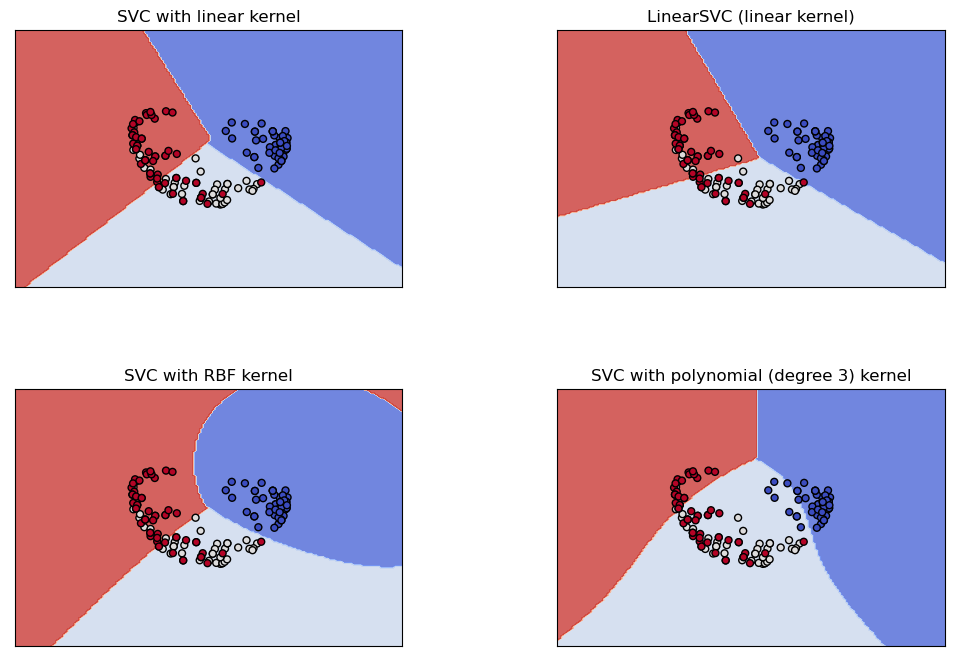

In [36]:
ker_reducer = dec.KernelPCA(kernel='rbf',n_components=2,fit_inverse_transform=True)
X_ker = ker_reducer.fit_transform(X)

compare_classifiers(X_ker,y, models, titles)

### Appendix G  Evaluating dimensionality reduction techniques as classifiers

The following idea is from the scikit learn docs.

We used LDA as as a classifier above, but let's try it on a problem with maany more classes (10)
and a much higher dimensionality,
digit recognition (each of the digit image's 64 pixels is a differen dimension).
Then let's compare it to other dimensionality reduction techniques, both supervised and
unsupervised.

Below we evaluate PCA, LDA and NCA (Neighborhood Components Analysis). NCA tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.  PCA, as we saw before, is unsupervised.

We will use the stochastic K Nearest Neighbor algorithm below.  We split the data into train and test sets,
We then train the reducers and transform the test sets. We then do KNN classification on the reduced
representations of the test sets.  That is, for each item in the test set,
we choose its class based on a vote of its k nearest neighbors (k=3).
The votes are weighted by their distance from the test item.
In NCA dimensionality reduction, the distances in turn are chosen 
so that members of the same class are closer.



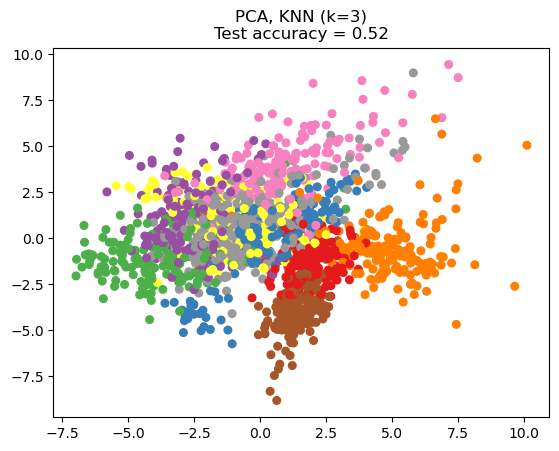

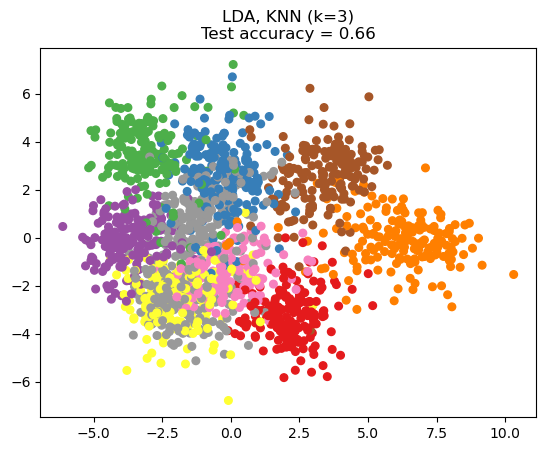

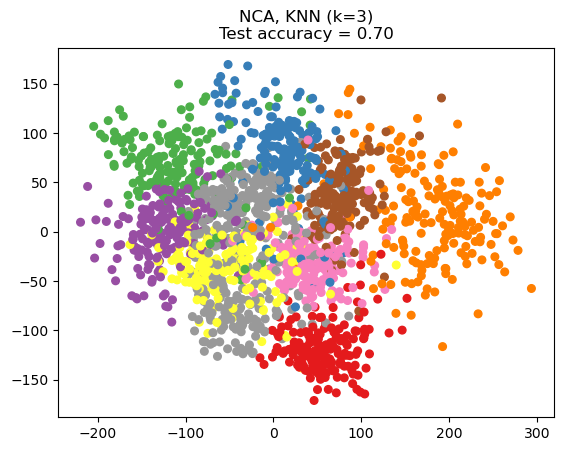

In [82]:
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# We'll use the 3 nearest neighbors for classification
n_neighbors = 3
random_state = 0

# Load Digits dataset
X, y = datasets.load_digits(return_X_y=True)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=random_state
)

dim = len(X[0])
n_classes = len(np.unique(y))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()

The picture points are colored by their true classes, and their positions
on the plot determined by the their reduced representation,
so, visually, what we are looking for is for all the points
of one color to be clustered together.  It's easy to see
the two supervised methods are doing a better job of that.

We also see that, with an accuracy of .70,
NCA does the best job of classifying. Not surprising, perhaps, given that it is optimized for this
classification algorithm.  But note that this is a 10-class classification
problem, so that the accuracy score of .52 that PCA achieves is actually not bad.

In [64]:
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In the plot below we switch back to classifying irises, but run the evaluation
10 times, printing out the average of the accuracy scores on 10 runs.  Note that
LDA establishes itself as the winner.  It is not doing as well (on average) as it did before
when we used Logistic Regression as the classifier, but in this dataset
it even beats NCA at its own game.

We also show the plot for the last of the 10 runs.

##  Same set of reducers on the iris data (multiple evaluation runs)

In [77]:
n_neighbors = 3

def eval_reducers(score_dict, X, y, random_state=None):
    embeddings = []
    if score_dict is None:
        score_dict=defaultdict(list)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=random_state
    )

    dim = len(X[0])
    n_classes = len(np.unique(y))

    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

    # Reduce dimension to 2 with LinearDiscriminantAnalysis
    lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

    # Reduce dimension to 2 with NeighborhoodComponentAnalysis
    nca = make_pipeline(
        StandardScaler(),
        NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
    )

    # Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    # Make a list of the methods to be compared
    dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

    # plt.figure()
    for i, (name, model) in enumerate(dim_reduction_methods):

        # Fit the method's model
        model.fit(X_train, y_train)

        # Fit a nearest neighbor classifier on the embedded training set
        knn.fit(model.transform(X_train), y_train)

        # Compute the nearest neighbor accuracy on the embedded test set
        acc_knn = knn.score(model.transform(X_test), y_test)
        score_dict[name].append(acc_knn)

        # Embed the data set in 2 dimensions using the fitted model
        embeddings.append(model.transform(X))

        
    return embeddings

In [84]:
# Split into train/test
from sklearn.datasets import load_iris
from collections import defaultdict

data = load_iris()
X = data['data']
feature_names = data['feature_names']
y = data['target']

NB You can also run the code cell below with X and y set to be the digit recognition data from
the previous example.  It will take longer/

PCA        91.6%
LDA        96.9%
NCA        95.3%


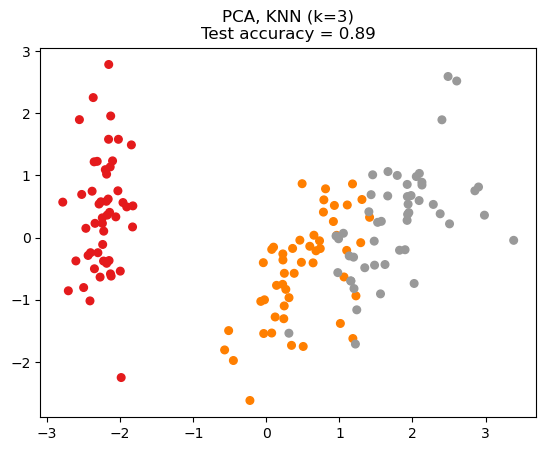

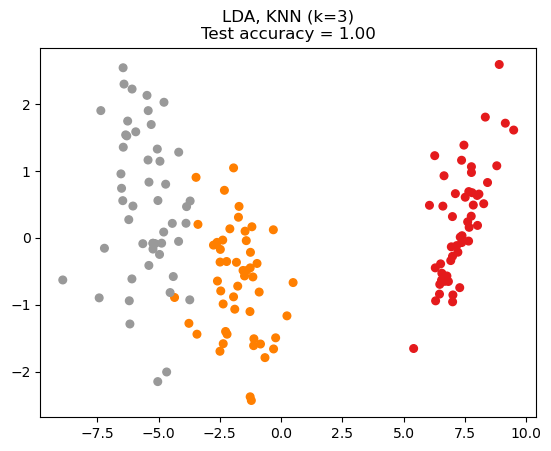

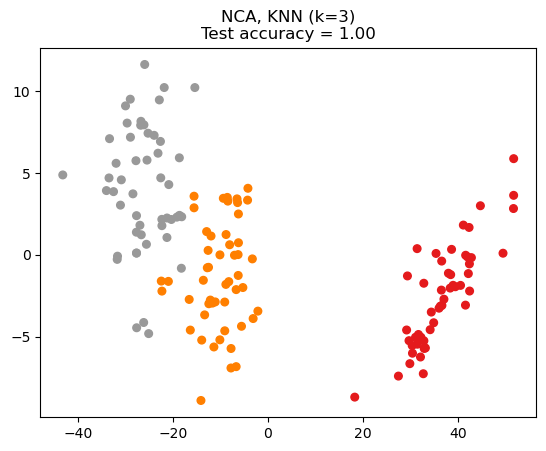

In [86]:
num_runs = 10
score_dict=defaultdict(list)
plot=False

for i in range(num_runs):
    if i == (num_runs - 1):
        plot = True
    embeddings = eval_reducers(score_dict, X, y)

# Print out averages
for (name,scores) in score_dict.items():
    print(f"{name:<10} {sum(scores)/num_runs:.1%}")
    

plt.figure()
# Plot the projected points and show the evaluation score
dim_reduction_methods = ["PCA", "LDA", "NCA"]
embeddings = zip(dim_reduction_methods,embeddings)
for (name,X_embedded) in embeddings:
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, score_dict[name][-1])#acc_knn)
                )
    plt.show()